<a href="https://colab.research.google.com/github/oxayavongsa/aai-530-iot-smart-house/blob/MODELS/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GlazeAlarm 2023
## Sensor 1: Front Door Data

In [1]:
# Install Libraries
#!pip install torch pytorch-lightning numpy pandas matplotlib scikit-learn pytorch-forecasting
#!pip install torch tensorflow GPUtil psutil
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

In [2]:
# Import Libraries
import os
import json
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import InputLayer, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import AdamW, Adam
from tensorflow.keras.regularizers import l2

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import torch
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping as PLEarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.metrics import RMSE

from datetime import datetime
import platform
import psutil
import subprocess

import torchmetrics
from torchmetrics import MeanAbsoluteError

from scipy.stats import zscore
import chardet

print("Necessary libraries imported successfully!")

Necessary libraries imported successfully!


# Checking Compute Info

In [3]:
# Load Kaggle credentials from JSON file
credentials_file = "kaggle_credentials.json"

if os.path.exists(credentials_file):
    with open(credentials_file, "r") as f:
        kaggle_credentials = json.load(f)

    kaggle_username = kaggle_credentials["username"]
    kaggle_key = kaggle_credentials["key"]

    print("Kaggle credentials loaded successfully.")
else:
    raise FileNotFoundError("Kaggle credentials file not found. Please create 'kaggle_credentials.json'.")

# Use inline authentication instead of a .kaggle directory
os.environ["KAGGLE_USERNAME"] = kaggle_username
os.environ["KAGGLE_KEY"] = kaggle_key

# Download the dataset from Kaggle
os.system("kaggle datasets download -d ssiatuos/smart-house-data-pack --quiet")

# Unzip the downloaded dataset
os.system("unzip -o smart-house-data-pack.zip -d ./smart-house-data-pack/ > /dev/null")

Kaggle credentials loaded successfully.


0

In [4]:
# Path to the Front Door CSV file
front_door_data = "./smart-house-data-pack/Smart House 2023 datapack CC BY-NC/GlazeAlarm 2023/Front Door.csv"

# Check and load Front Door dataset
if os.path.exists(front_door_data):
    try:
        df_front_door = pd.read_csv(front_door_data, header=0, index_col=False)
        print("Front Door Dataset loaded successfully.")
    except Exception as e:
        print(f"Error loading Front Door dataset: {e}")

# Path to the EcoLab Ground CSV file
ecolab_data = "./smart-house-data-pack/Smart House 2023 datapack CC BY-NC/Invisible Systems 2023/EcoLab Ground.csv"

# Check and load EcoLab Ground dataset
if os.path.exists(ecolab_data):
    try:
        df_inv = pd.read_csv(ecolab_data, header=0, index_col=False, engine="python")
        print("EcoLab Ground Dataset loaded successfully.")
    except Exception as e:
        print(f"Error loading EcoLab Ground dataset: {e}")

# Path to the Weather Link Indoor CSV file
weather_data = "./smart-house-data-pack/Smart House 2023 datapack CC BY-NC/WeatherLink Indoor and Outdoor 2023/Weather Link Indoor.csv"

# Detect encoding to handle special characters in the dataset
if os.path.exists(weather_data):
    try:
        with open(weather_data, "rb") as f:
            encoding_result = chardet.detect(f.read())
        detected_encoding = encoding_result.get("encoding", "ISO-8859-1")

        # Load Weather Link Indoor dataset
        df_wLink = pd.read_csv(
            weather_data,
            engine="python",
            encoding=detected_encoding,
            skiprows=5
        )
        print("Weather Link Indoor Dataset loaded successfully.")
    except Exception as e:
        print(f"Error loading Weather Link Indoor dataset: {e}")

Front Door Dataset loaded successfully.
EcoLab Ground Dataset loaded successfully.
Weather Link Indoor Dataset loaded successfully.


### Data Understanding and EDA

In [5]:
# Shape of DataFrame
df_front_door.shape

(1185, 7)

In [6]:
# Dataframe Info
df_front_door.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1185 entries, 0 to 1184
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Timestamp      1185 non-null   object
 1   Serial Number  1185 non-null   int64 
 2   Name           1185 non-null   object
 3   Mode           1185 non-null   object
 4   Alarm          1185 non-null   object
 5   rH             1185 non-null   object
 6   Temp           1185 non-null   object
dtypes: int64(1), object(6)
memory usage: 64.9+ KB


In [7]:
# Display the first 5 rows of the dataset
df_head = df_front_door.head(5)

# Display the last 5 rows of the dataset
df_tail = df_front_door.tail(5)

df_head
df_tail

Timestamp  Serial Number        Name      Mode     Alarm  \
1180  2022-03-28 15:41:09           1095  Front Door  LEARNING     RESET   
1181  2022-03-23 19:30:38           1095  Front Door     STATE  PRE-WARN   
1182  2022-03-23 19:30:32           1095  Front Door     STATE     RESET   
1183  2022-03-23 19:29:50           1095  Front Door     STATE  PRE-WARN   
1184  2022-03-23 19:29:43           1095  Front Door  LEARNING     RESET   

        rH  Temp  
1180     -     -  
1181  36.5    25  
1182  36.5    25  
1183  38.1  21.1  
1184     -     -

In [8]:
# Missing Data
df_front_door.isnull().sum()

Timestamp        0
Serial Number    0
Name             0
Mode             0
Alarm            0
rH               0
Temp             0
dtype: int64

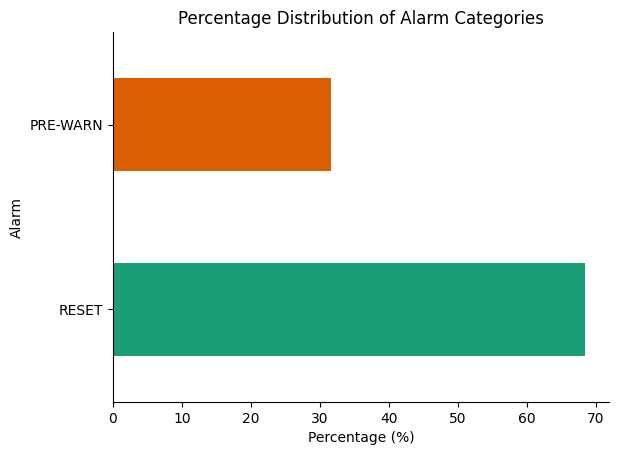

In [9]:
# Calculate the percentage of each 'Alarm' category
alarm_counts = df_front_door['Alarm'].value_counts(normalize=True) * 100

# Plot the horizontal bar chart with percentages
alarm_counts.plot(kind='barh', color=sns.color_palette('Dark2', len(alarm_counts)))

# Display chart
plt.xlabel('Percentage (%)')
plt.ylabel('Alarm')
plt.title('Percentage Distribution of Alarm Categories')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

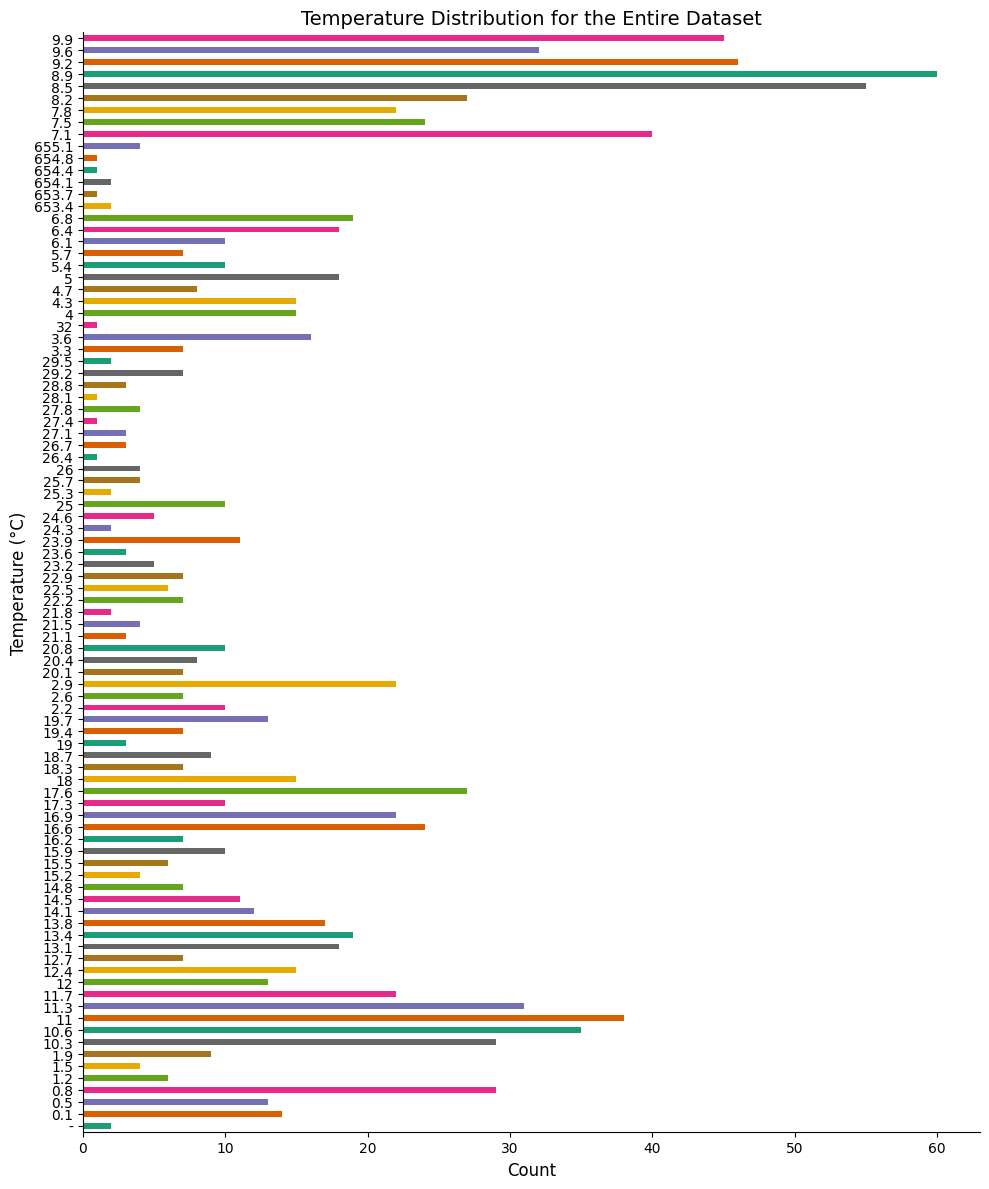

In [10]:
# Check if the original dataset is not empty
if not df_front_door.empty:
    # Group by 'Temp' column and plot the distribution for the entire dataset with a larger figure size
    plt.figure(figsize=(10, 12))
    df_front_door.groupby('Temp').size().plot(kind='barh', color=sns.color_palette('Dark2'))

    # Add labels and title
    plt.title('Temperature Distribution for the Entire Dataset', fontsize=14)
    plt.xlabel('Count', fontsize=12)
    plt.ylabel('Temperature (°C)', fontsize=12)
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.tight_layout()
    plt.show()
else:
    print("The dataset is empty. Cannot plot temperature distribution.")

*Values like 653.7°C are unrealistic so I will need to correct temperatures above 50°C*

### Data Clean and Preprocessing

In [11]:
# Convert the 'Temp' column to numeric, replacing non-numeric values with NaN
df_front_door['Temp'] = pd.to_numeric(df_front_door['Temp'], errors='coerce')

# Replace anomalous high temperature values (above a reasonable threshold) with NaN
reasonable_temp_threshold = 60  # Assuming temperatures above 50°C are unrealistic
df_front_door['Temp'] = df_front_door['Temp'].where(df_front_door['Temp'] <= reasonable_temp_threshold, np.nan)

# Fill NaN values with the mean temperature of the dataset (after removing anomalies)
mean_temp = df_front_door['Temp'].mean(skipna=True)
df_front_door['Temp'] = df_front_door['Temp'].fillna(mean_temp)

# Verify the changes
print(df_front_door['Temp'].describe())

count    1185.000000
mean       11.173976
std         6.354127
min         0.100000
25%         7.100000
50%         9.900000
75%        14.800000
max        32.000000
Name: Temp, dtype: float64


*The 25th percentile is 7.1°C, the median is 9.9°C, and the 75th percentile is 14.8°C, showing a well-spread distribution.*

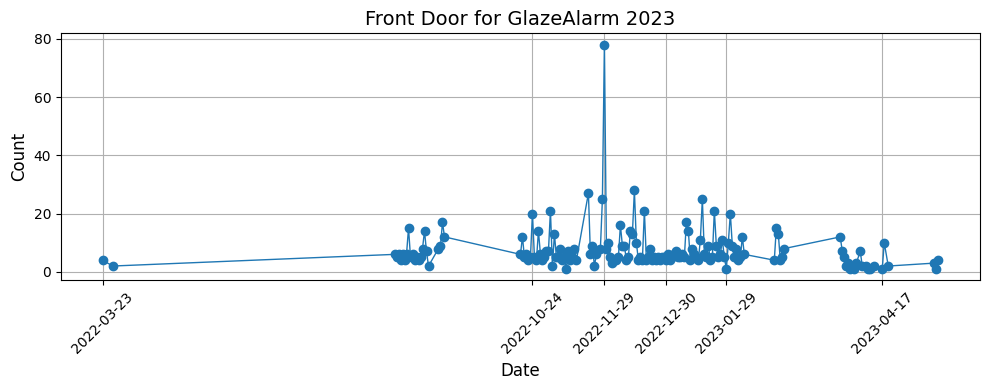

In [12]:
# Convert the 'Timestamp' column to datetime
df_front_door['Timestamp'] = pd.to_datetime(df_front_door['Timestamp'], errors='coerce')

# Sort the DataFrame by 'Timestamp'
df_front_door = df_front_door.sort_values(by='Timestamp')

# Group data by date for the line chart
df_front_door['Date'] = df_front_door['Timestamp'].dt.date
daily_data = df_front_door.groupby('Date').size()

# Plot the line chart including the full timestamp
plt.figure(figsize=(10, 4))
plt.plot(daily_data.index, daily_data.values, marker='o', linestyle='-', linewidth=1)
plt.title('Front Door for GlazeAlarm 2023', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(True)
plt.xticks(daily_data.index[::30], rotation=45)
plt.tight_layout()
plt.show()

*Further Analysis is needed for the Outlier shown in the chart*

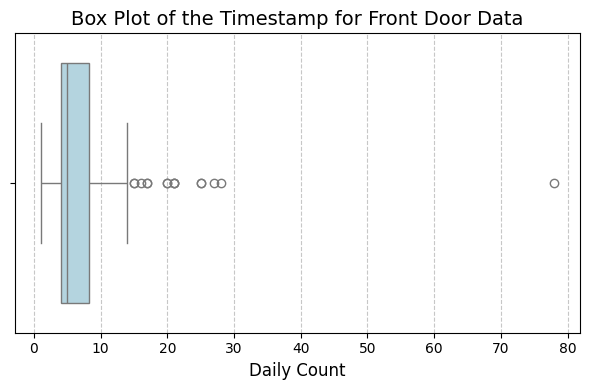

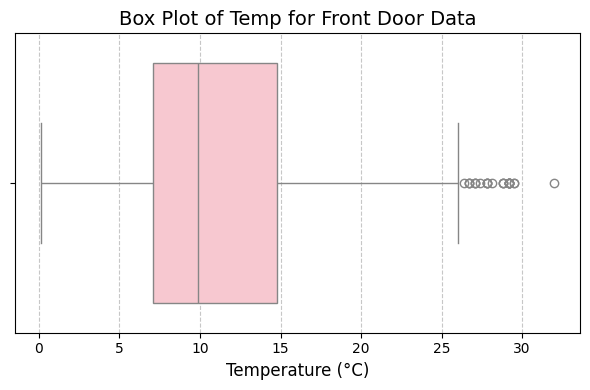

In [13]:
# Boxplot display
daily_counts = df_front_door.groupby('Date').size().reset_index(name='Count')

# Create a box plot for the daily counts to detect outliers
plt.figure(figsize=(6, 4))
sns.boxplot(x=daily_counts['Count'], color='lightblue')
plt.title('Box Plot of the Timestamp for Front Door Data', fontsize=14)
plt.xlabel('Daily Count', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Create a box plot for the 'Temp' column to detect outliers
plt.figure(figsize=(6, 4))
sns.boxplot(x=df_front_door['Temp'], color='pink')
plt.title('Box Plot of Temp for Front Door Data', fontsize=14)
plt.xlabel('Temperature (°C)', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [14]:
# Identify the date corresponding to the outlier in daily counts
outlier_threshold = daily_counts['Count'].quantile(0.75) + 1.5 * (daily_counts['Count'].quantile(0.75) - daily_counts['Count'].quantile(0.25))

# Filter for outlier days
outlier_days = daily_counts[daily_counts['Count'] > outlier_threshold]

# Display the outlier days and their counts
outlier_days

Date  Count
9    2022-08-23     15
22   2022-09-09     17
30   2022-10-24     20
39   2022-11-02     21
53   2022-11-21     27
59   2022-11-28     25
60   2022-11-29     78
67   2022-12-07     16
74   2022-12-14     28
79   2022-12-19     21
100  2023-01-09     17
108  2023-01-17     25
114  2023-01-23     21
122  2023-01-31     20
131  2023-02-23     15

*The outlier on 2022-11-29 is valid and reflects real activity logged by the system so a correction isn't needed*

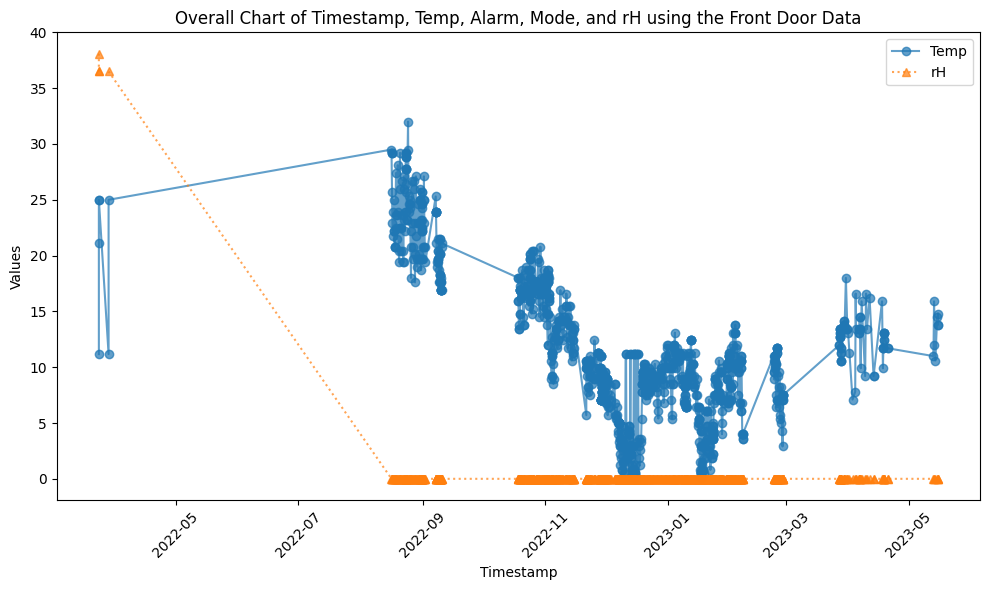

In [15]:
# Convert non-numerical values in 'Mode' and 'Alarm' columns to numerical
# df_front_door['Mode'] = df_front_door['Mode'].astype('category').cat.codes
# df_front_door['Alarm'] = df_front_door['Alarm'].astype('category').cat.codes

# Step 3: Plot a combined graph for Timestamp, Alarm, Mode, rH, and Temp
plt.figure(figsize=(10, 6))

# Timestamp vs Temp
plt.plot(df_front_door['Timestamp'], df_front_door['Temp'], label='Temp', marker='o', linestyle='-', alpha=0.7)

# Timestamp vs Alarm
# plt.plot(df_front_door['Timestamp'], df_front_door['Alarm'], label='Alarm', marker='x', linestyle='--', alpha=0.7)

# Timestamp vs Mode
# plt.plot(df_front_door['Timestamp'], df_front_door['Mode'], label='Mode', marker='s', linestyle='-.', alpha=0.7)

# Timestamp vs rH
df_front_door['rH'] = pd.to_numeric(df_front_door['rH'], errors='coerce')
plt.plot(df_front_door['Timestamp'], df_front_door['rH'], label='rH', marker='^', linestyle=':', alpha=0.7)

# Adding labels, legend, and layout adjustments
plt.title('Overall Chart of Timestamp, Temp, Alarm, Mode, and rH using the Front Door Data')
plt.xlabel('Timestamp')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
# Confirm the correction
print(df_front_door['rH'].describe())

count    1183.000000
mean        0.124768
std         2.143330
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        38.100000
Name: rH, dtype: float64


*The statistics confirm that the rH data is highly skewed and dominated by zeros, making it less meaningful for modeling purposes. It is reasonable to drop the rH column as it doesn't add significant value to the objective or target variable prediction.*

In [17]:
# Drop the 'rH', 'Serial Number', and 'Name' columns from the dataset
df_cleaned = df_front_door.drop(columns=['rH', 'Serial Number', 'Name'])

In [18]:
# Define the cutoff date
cutoff_date = '2022-08-15'

# Convert the cutoff date to a datetime object
cutoff_date = pd.to_datetime(cutoff_date)

# Filter the dataset and create a new copy to avoid SettingWithCopyWarning
df_cleaned1 = df_cleaned[df_cleaned['Timestamp'] >= cutoff_date].copy()

# Handle Missing or Erroneous Temperature Values
df_cleaned1['Temp'] = pd.to_numeric(df_cleaned1['Temp'], errors='coerce')  # Convert Temp to numeric
reasonable_temp_threshold = 50  # Define a reasonable max Temp
df_cleaned1['Temp'] = df_cleaned1['Temp'].where(df_cleaned1['Temp'] <= reasonable_temp_threshold, np.nan)  # Replace outliers
df_cleaned1['Temp'] = df_cleaned1['Temp'].interpolate(method='linear', limit_direction='both')  # Interpolate missing values

# Convert and Validate Timestamp
df_cleaned1['Timestamp'] = pd.to_datetime(df_cleaned1['Timestamp'], errors='coerce')  # Convert to datetime
df_cleaned1 = df_cleaned1.dropna(subset=['Timestamp'])  # Drop rows with invalid timestamps

# Validate `Mode` and `Alarm` Columns
# Ensure all values in Mode and Alarm are within a valid range
if df_cleaned1['Mode'].isnull().any() or df_cleaned1['Alarm'].isnull().any():
    print("Warning: Null values found in Mode or Alarm columns. Consider imputing them.")

# Validate and Display Final Cleaned Data
print("Cleaned Data After 8/15/2022:")
print(df_cleaned1.info())
print(df_cleaned1.head())

Cleaned Data After 8/15/2022:
<class 'pandas.core.frame.DataFrame'>
Index: 1179 entries, 1178 to 0
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Timestamp  1179 non-null   datetime64[ns]
 1   Mode       1179 non-null   object        
 2   Alarm      1179 non-null   object        
 3   Temp       1179 non-null   float64       
 4   Date       1179 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 55.3+ KB
None
               Timestamp   Mode     Alarm  Temp        Date
1178 2022-08-16 11:24:21  STATE     RESET  29.5  2022-08-16
1177 2022-08-16 12:16:09  STATE  PRE-WARN  29.2  2022-08-16
1176 2022-08-16 12:16:53  STATE     RESET  29.2  2022-08-16
1175 2022-08-16 12:17:12  STATE  PRE-WARN  29.2  2022-08-16
1174 2022-08-16 17:37:52  STATE     RESET  25.7  2022-08-16


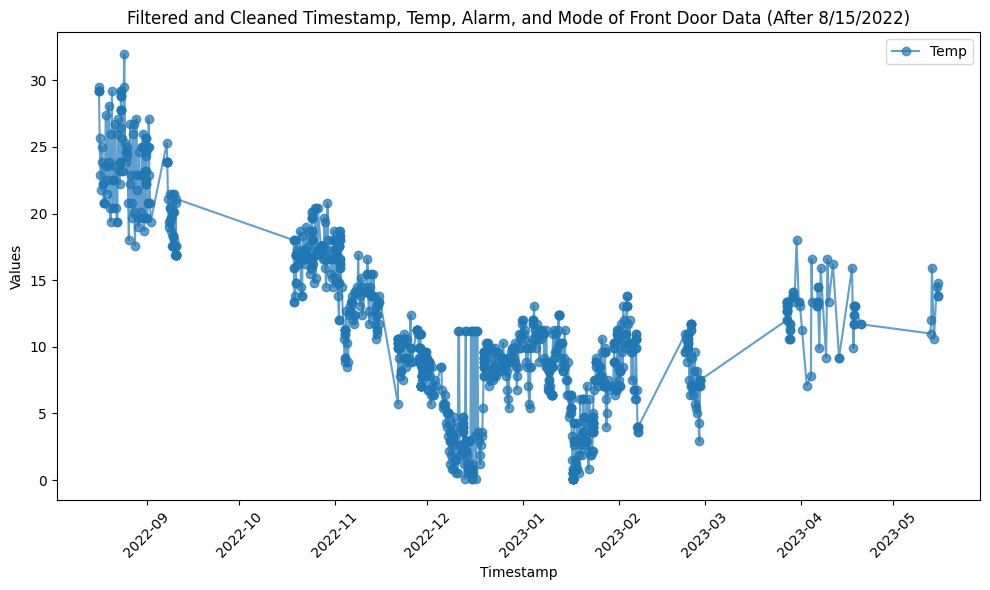

In [19]:
# Visualize the updated data to confirm
plt.figure(figsize=(10, 6))
plt.plot(df_cleaned1['Timestamp'], df_cleaned1['Temp'], label='Temp', marker='o', linestyle='-', alpha=0.7)
# plt.plot(df_cleaned1['Timestamp'], df_cleaned1['Alarm'], label='Alarm', marker='x', linestyle='--', alpha=0.7)
# plt.plot(df_cleaned1['Timestamp'], df_cleaned1['Mode'], label='Mode', marker='s', linestyle='-.', alpha=0.7)
plt.title('Filtered and Cleaned Timestamp, Temp, Alarm, and Mode of Front Door Data (After 8/15/2022)')
plt.xlabel('Timestamp')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

*Display Data for Front Door Data in 3 Month Range*

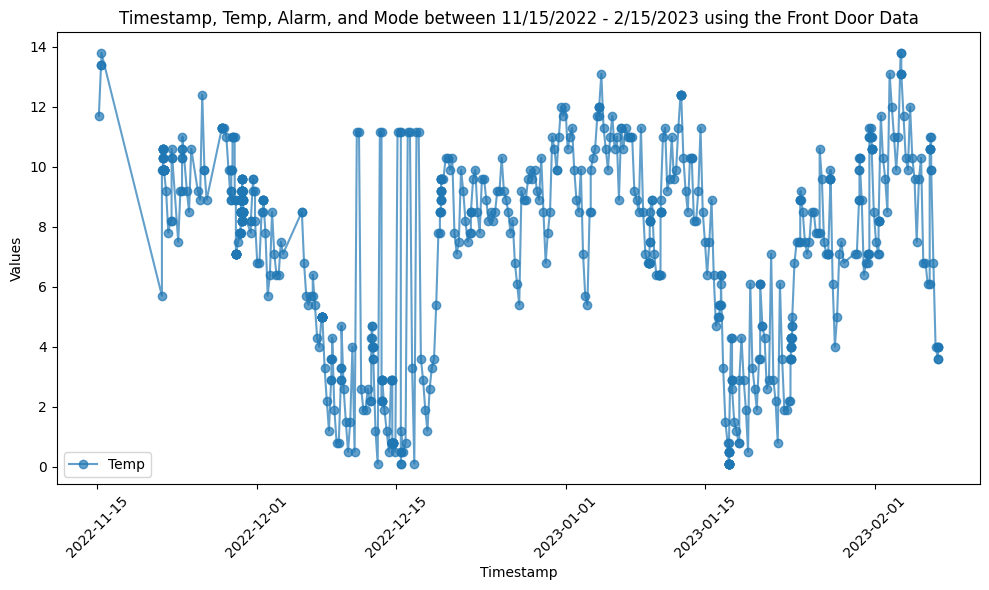

In [20]:
# Filter the DataFrame to include only data between 11/2022 and 2/2023
df_filtered = df_cleaned1[(df_cleaned1['Timestamp'] >= '2022-11-15') & (df_cleaned1['Timestamp'] <= '2023-02-15')]

# Plot the combined graph for the filtered data
plt.figure(figsize=(10, 6))

# Timestamp vs Temp
plt.plot(df_filtered['Timestamp'], df_filtered['Temp'], label='Temp', marker='o', linestyle='-', alpha=0.7)

# Timestamp vs Alarm
# plt.plot(df_filtered['Timestamp'], df_filtered['Alarm'], label='Alarm', marker='x', linestyle='--', alpha=0.7)

# Timestamp vs Mode
# plt.plot(df_filtered['Timestamp'], df_filtered['Mode'], label='Mode', marker='s', linestyle='-.', alpha=0.7)

# Adding labels, legend, and layout adjustments
plt.title('Timestamp, Temp, Alarm, and Mode between 11/15/2022 - 2/15/2023 using the Front Door Data')
plt.xlabel('Timestamp')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

*Saved Clean Version of Front Door Data to Use for Model Predictions*

In [21]:
# Ensure the directory exists
output_dir = "./data"
os.makedirs(output_dir, exist_ok=True)

# Define the output file path
cleaned_df1 = os.path.join(output_dir, "Front Door Cleaned.csv")

# Save the filtered and cleaned dataset
df_cleaned1.to_csv(cleaned_df1, index=False)

# Confirm the save operation
cleaned_df1

'./data/Front Door Cleaned.csv'

# Invisible Systems 2023
## Sensor 2: EcoLab Ground Data

*We are using EcoLab Ground as that has ppm, rH and Temperature. Smarthouse Ground floor has alot more but more sensors that don't have full meaning to this project like IAQ, VOC, Light, Floor pressure and Floor temperature*

In [22]:
# Aaron's File Path
# data = "./Smart House 2023 datapack CC BY-NC/Invisible Systems 2023/EcoLab Ground.csv"

### Data Understanding and EDA



In [23]:
# Check Dataframe
df_inv.head()

Sensor             DateTime  Value  Max  Min Unit
0  EcoLab Ground (CO107)  2022-12-31 23:53:24  518.0  NaN  NaN  ppm
1  EcoLab Ground (CO107)  2023-01-01 00:00:55  520.0  NaN  NaN  ppm
2  EcoLab Ground (CO107)  2023-01-01 00:08:23  505.0  NaN  NaN  ppm
3  EcoLab Ground (CO107)  2023-01-01 00:15:52  491.0  NaN  NaN  ppm
4  EcoLab Ground (CO107)  2023-01-01 00:23:22  509.0  NaN  NaN  ppm

In [24]:
# Remove the 'Max' and 'Min' columns
df_inv = df_inv.drop(columns=['Max', 'Min'])
df_inv['DateTime'] = pd.to_datetime(df_inv['DateTime'])

In [25]:
df_inv.shape
df_inv.info()
df_inv.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179682 entries, 0 to 179681
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Sensor    179682 non-null  object        
 1   DateTime  179682 non-null  datetime64[ns]
 2   Value     179682 non-null  float64       
 3   Unit      179682 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 5.5+ MB


Sensor            DateTime  Value Unit
0  EcoLab Ground (CO107) 2022-12-31 23:53:24  518.0  ppm
1  EcoLab Ground (CO107) 2023-01-01 00:00:55  520.0  ppm
2  EcoLab Ground (CO107) 2023-01-01 00:08:23  505.0  ppm
3  EcoLab Ground (CO107) 2023-01-01 00:15:52  491.0  ppm
4  EcoLab Ground (CO107) 2023-01-01 00:23:22  509.0  ppm

In [26]:
# Filter data for each unit
df_ppm = df_inv[df_inv['Unit'] == 'ppm']  # For ppm
df_rh = df_inv[df_inv['Unit'] == '%RH']   # For %RH
df_c = df_inv[df_inv['Unit'] == '°C']     # For °C

# Check the filtered data
print(df_ppm.head())
print(df_rh.head())
print(df_c.head())

                  Sensor            DateTime  Value Unit
0  EcoLab Ground (CO107) 2022-12-31 23:53:24  518.0  ppm
1  EcoLab Ground (CO107) 2023-01-01 00:00:55  520.0  ppm
2  EcoLab Ground (CO107) 2023-01-01 00:08:23  505.0  ppm
3  EcoLab Ground (CO107) 2023-01-01 00:15:52  491.0  ppm
4  EcoLab Ground (CO107) 2023-01-01 00:23:22  509.0  ppm
                     Sensor            DateTime  Value Unit
59894  EcoLab Ground (H107) 2022-12-31 23:53:24   73.0  %RH
59895  EcoLab Ground (H107) 2023-01-01 00:00:55   73.0  %RH
59896  EcoLab Ground (H107) 2023-01-01 00:08:23   73.0  %RH
59897  EcoLab Ground (H107) 2023-01-01 00:15:52   73.0  %RH
59898  EcoLab Ground (H107) 2023-01-01 00:23:22   73.0  %RH
                      Sensor            DateTime  Value Unit
119788  EcoLab Ground (T107) 2022-12-31 23:53:24   12.3   °C
119789  EcoLab Ground (T107) 2023-01-01 00:00:55   12.4   °C
119790  EcoLab Ground (T107) 2023-01-01 00:08:23   12.4   °C
119791  EcoLab Ground (T107) 2023-01-01 00:15:52   12.

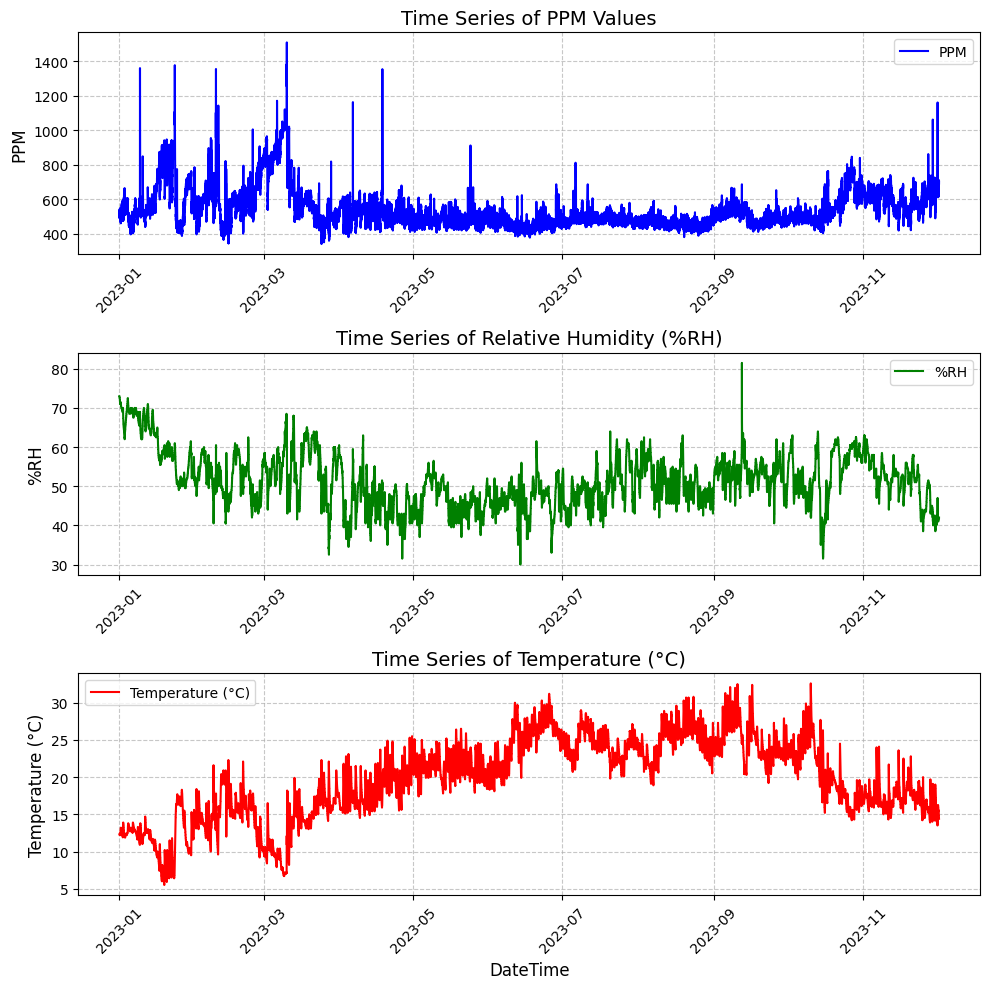

In [27]:
# Visualizing EcoLab Ground Data: PPM, RH, and Temperature
fig, axes = plt.subplots(3, 1, figsize=(10, 10))

# Plot ppm
axes[0].plot(df_ppm['DateTime'], df_ppm['Value'], color='blue', label='PPM')
axes[0].set_title('Time Series of PPM Values', fontsize=14)
axes[0].set_ylabel('PPM', fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].legend(fontsize=10)

# Plot %RH
axes[1].plot(df_rh['DateTime'], df_rh['Value'], color='green', label='%RH')
axes[1].set_title('Time Series of Relative Humidity (%RH)', fontsize=14)
axes[1].set_ylabel('%RH', fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].legend(fontsize=10)

# Plot °C
axes[2].plot(df_c['DateTime'], df_c['Value'], color='red', label='Temperature (°C)')
axes[2].set_title('Time Series of Temperature (°C)', fontsize=14)
axes[2].set_xlabel('DateTime', fontsize=12)
axes[2].set_ylabel('Temperature (°C)', fontsize=12)
axes[2].grid(True, linestyle='--', alpha=0.7)
axes[2].legend(fontsize=10)

# Adjust x-axis labels for better readability
for ax in axes:
    ax.tick_params(axis='x', rotation=45)

# Adjust layout for clarity
plt.tight_layout()
plt.show()

### Data Clean and Preprocessing
*Handle Outliers in EcoLab Ground Data*

In [28]:
# Convert DateTime column to datetime format
df_inv['DateTime'] = pd.to_datetime(df_inv['DateTime'], errors='coerce')

# Remove rows with invalid DateTime or missing data
df_inv = df_inv.dropna(subset=['DateTime', 'Value'])

# Filter dataset for relevant units: ppm, %RH, °C
df_ppm = df_inv[df_inv['Unit'] == 'ppm'].copy()
df_rh = df_inv[df_inv['Unit'] == '%RH'].copy()
df_temp = df_inv[df_inv['Unit'] == '°C'].copy()

# Ensure 'Value' column is numeric
df_ppm['Value'] = pd.to_numeric(df_ppm['Value'], errors='coerce')
df_rh['Value'] = pd.to_numeric(df_rh['Value'], errors='coerce')
df_temp['Value'] = pd.to_numeric(df_temp['Value'], errors='coerce')

# Handle outliers and interpolate
# PPM
ppm_threshold = 3000  # Set threshold
df_ppm['Value'] = df_ppm['Value'].where(df_ppm['Value'] <= ppm_threshold, np.nan)
df_ppm['Value'] = df_ppm['Value'].interpolate(method='linear', limit_direction='both')

# %RH
rh_min, rh_max = 10, 90  # Set reasonable range for %RH
df_rh['Value'] = df_rh['Value'].where((df_rh['Value'] >= rh_min) & (df_rh['Value'] <= rh_max), np.nan)
df_rh['Value'] = df_rh['Value'].interpolate(method='linear', limit_direction='both')

# Temperature (°C)
temp_threshold = 60  # Set threshold
df_temp['Value'] = df_temp['Value'].where(df_temp['Value'] <= temp_threshold, np.nan)
df_temp['Value'] = df_temp['Value'].interpolate(method='linear', limit_direction='both')

# Combine cleaned datasets
df2_clean = pd.concat([df_ppm, df_rh, df_temp]).sort_values(by="DateTime").reset_index(drop=True)

# Verify the structure of the cleaned dataset
print(df2_clean.head())

                  Sensor            DateTime  Value Unit
0  EcoLab Ground (CO107) 2022-12-31 23:53:24  518.0  ppm
1   EcoLab Ground (H107) 2022-12-31 23:53:24   73.0  %RH
2   EcoLab Ground (T107) 2022-12-31 23:53:24   12.3   °C
3  EcoLab Ground (CO107) 2023-01-01 00:00:55  520.0  ppm
4   EcoLab Ground (H107) 2023-01-01 00:00:55   73.0  %RH


In [29]:
# Display the column names of the cleaned dataset
df2_clean.columns

Index(['Sensor', 'DateTime', 'Value', 'Unit'], dtype='object')

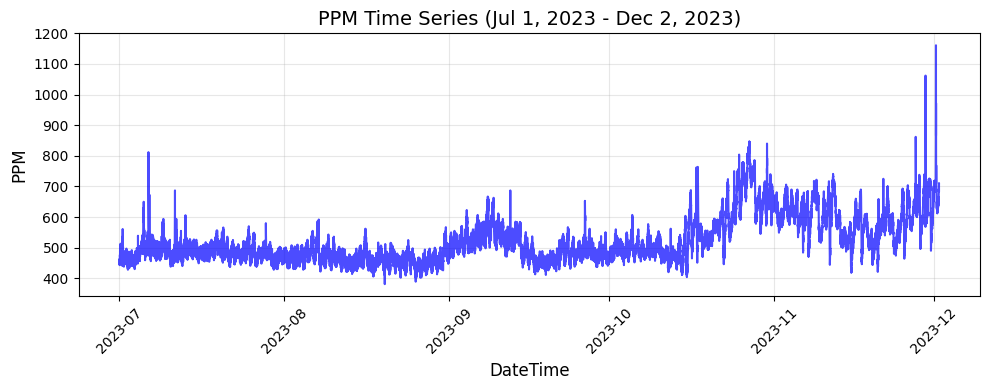

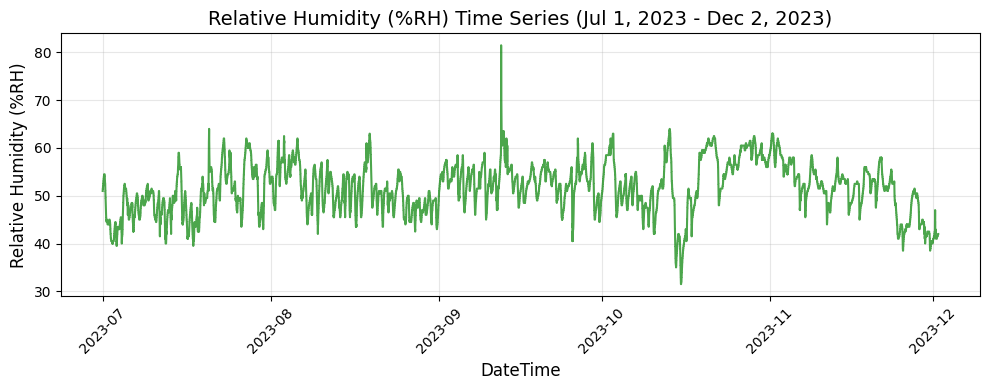

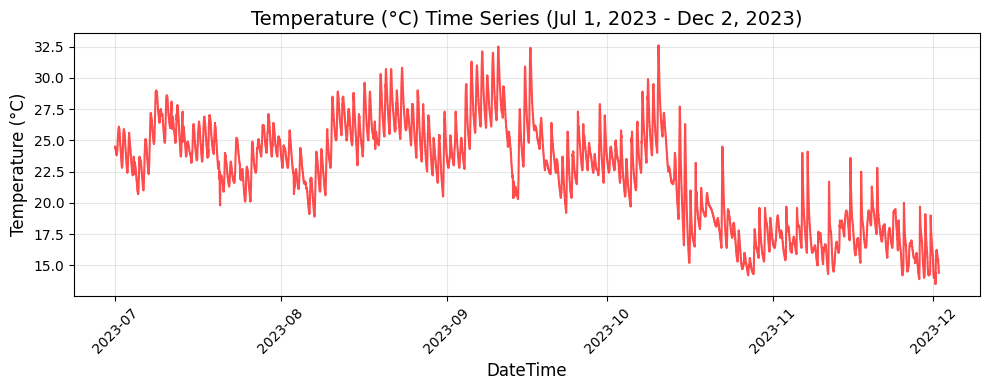

In [30]:
# Filter each subset for the date range
start_date = '2023-07-01'
end_date = '2023-12-02'
df_ppm_filtered = df_ppm[(df_ppm['DateTime'] >= start_date) & (df_ppm['DateTime'] <= end_date)]
df_rh_filtered = df_rh[(df_rh['DateTime'] >= start_date) & (df_rh['DateTime'] <= end_date)]
df_temp_filtered = df_temp[(df_temp['DateTime'] >= start_date) & (df_temp['DateTime'] <= end_date)]

# Plotting PPM
plt.figure(figsize=(10, 4))
plt.plot(df_ppm_filtered['DateTime'], df_ppm_filtered['Value'], label='PPM', color='blue', alpha=0.7)
plt.title('PPM Time Series (Jul 1, 2023 - Dec 2, 2023)', fontsize=14)
plt.xlabel('DateTime', fontsize=12)
plt.ylabel('PPM', fontsize=12)
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Plotting RH
plt.figure(figsize=(10, 4))
plt.plot(df_rh_filtered['DateTime'], df_rh_filtered['Value'], label='%RH', color='green', alpha=0.7)
plt.title('Relative Humidity (%RH) Time Series (Jul 1, 2023 - Dec 2, 2023)', fontsize=14)
plt.xlabel('DateTime', fontsize=12)
plt.ylabel('Relative Humidity (%RH)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Plotting Temperature
plt.figure(figsize=(10, 4))
plt.plot(df_temp_filtered['DateTime'], df_temp_filtered['Value'], label='Temp (°C)', color='red', alpha=0.7)
plt.title('Temperature (°C) Time Series (Jul 1, 2023 - Dec 2, 2023)', fontsize=14)
plt.xlabel('DateTime', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

*Saved Clean Version of EcoLab Ground Data to Use for Model Predictions*

In [31]:
# Define the output directory and file path
output_dir = "./data"
os.makedirs(output_dir, exist_ok=True)
cleaned_df2 = os.path.join(output_dir, "EcoLab Ground Cleaned.csv")

# Save the cleaned dataset to a CSV file
df2_clean.to_csv(cleaned_df2, index=False)

cleaned_df2

'./data/EcoLab Ground Cleaned.csv'

# Weather Link Indoor and Outdoor 2023
## Sensor 3 Data: Weather Link Indoor

### Data Understanding and EDA

In [32]:
# Dataframe Initial Head
df_wLink.head()

Date & Time  Inside Temp - °C  High Inside Temp - °C  \
0  1/1/23 00:00                13                     13   
1  1/1/23 00:15                13                     13   
2  1/1/23 00:30                13                     13   
3  1/1/23 00:45                13                     14   
4  1/1/23 01:00                13                     14   

   Low Inside Temp - °C  Inside Hum - %  High Inside Hum - %  \
0                    13              68                   68   
1                    13              68                   69   
2                    13              68                   69   
3                    13              68                   68   
4                    13              68                   68   

   Low Inside Hum - %  Inside Dew Point - °C  Inside Heat Index - °C  \
0                  68                      8                      13   
1                  68                      8                      13   
2                  68                      8                      13   
3                  68                      8                      13   
4                  68                      8                      13   

   Barometer - mb  High Bar - mb  Low Bar - mb  Absolute Pressure - mb  
0          1002.6         1002.6        1002.6                   999.6  
1          1002.7         1002.8        1002.6                   999.7  
2          1002.6         1002.9        1002.6                   999.6  
3          1002.7         1002.9        1002.6                   999.8  
4          1002.7         1002.8        1002.7                   999.7

In [33]:
# Print Initial Data
df_wLink.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52864 entries, 0 to 52863
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date & Time             52864 non-null  object 
 1   Inside Temp - °C        52864 non-null  int64  
 2   High Inside Temp - °C   52864 non-null  int64  
 3   Low Inside Temp - °C    52864 non-null  int64  
 4   Inside Hum - %          52864 non-null  int64  
 5   High Inside Hum - %     52864 non-null  int64  
 6   Low Inside Hum - %      52864 non-null  int64  
 7   Inside Dew Point - °C   52864 non-null  int64  
 8   Inside Heat Index - °C  52864 non-null  int64  
 9   Barometer - mb          52864 non-null  float64
 10  High Bar - mb           52864 non-null  float64
 11  Low Bar - mb            52864 non-null  float64
 12  Absolute Pressure - mb  52864 non-null  float64
dtypes: float64(4), int64(8), object(1)
memory usage: 5.2+ MB


### Data Cleaning and Preprocessing

*Feature Engineering*

In [34]:
# Create the cleaned dataset
df_wLink_cleaned = df_wLink.copy()

# Retain Relevant Columns and Create Derived Features
df_wLink_cleaned['Temp Range - °C'] = df_wLink_cleaned['High Inside Temp - °C'] - df_wLink_cleaned['Low Inside Temp - °C']
df_wLink_cleaned['Humidity Range - %'] = df_wLink_cleaned['High Inside Hum - %'] - df_wLink_cleaned['Low Inside Hum - %']
df_wLink_cleaned['Pressure Range - mb'] = df_wLink_cleaned['High Bar - mb'] - df_wLink_cleaned['Low Bar - mb']

# Remove Unnecessary Columns
df_wLink_cleaned = df_wLink_cleaned.drop(columns=[
    'High Inside Temp - °C', 'Low Inside Temp - °C',
    'High Inside Hum - %', 'Low Inside Hum - %',
    'High Bar - mb', 'Low Bar - mb'
])

*Standardize Date Format*

In [35]:
# Standardize the Date Format
def standardize_date(date_str):
    try:
        dt = datetime.strptime(date_str, "%d/%m/%Y %H:%M")  # e.g., "1/1/2023 0:00"
    except ValueError:
        try:
            dt = datetime.strptime(date_str, "%d/%m/%y %H:%M")  # e.g., "13/1/23 00:00"
        except ValueError:
            return None
    return dt.strftime("%Y-%m-%d %H:%M:%S")

df_wLink_cleaned['Date & Time'] = df_wLink_cleaned['Date & Time'].apply(standardize_date)
df_wLink_cleaned['Date & Time'] = pd.to_datetime(df_wLink_cleaned['Date & Time'])

*Display Clean Data*

In [36]:
# Verify the Cleaned DataFrame
df_wLink_cleaned.info()
df_wLink_cleaned.head()

# Print New Columns
df_wLink_cleaned.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52864 entries, 0 to 52863
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date & Time             52864 non-null  datetime64[ns]
 1   Inside Temp - °C        52864 non-null  int64         
 2   Inside Hum - %          52864 non-null  int64         
 3   Inside Dew Point - °C   52864 non-null  int64         
 4   Inside Heat Index - °C  52864 non-null  int64         
 5   Barometer - mb          52864 non-null  float64       
 6   Absolute Pressure - mb  52864 non-null  float64       
 7   Temp Range - °C         52864 non-null  int64         
 8   Humidity Range - %      52864 non-null  int64         
 9   Pressure Range - mb     52864 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(6)
memory usage: 4.0 MB


Index(['Date & Time', 'Inside Temp - °C', 'Inside Hum - %',
       'Inside Dew Point - °C', 'Inside Heat Index - °C', 'Barometer - mb',
       'Absolute Pressure - mb', 'Temp Range - °C', 'Humidity Range - %',
       'Pressure Range - mb'],
      dtype='object')

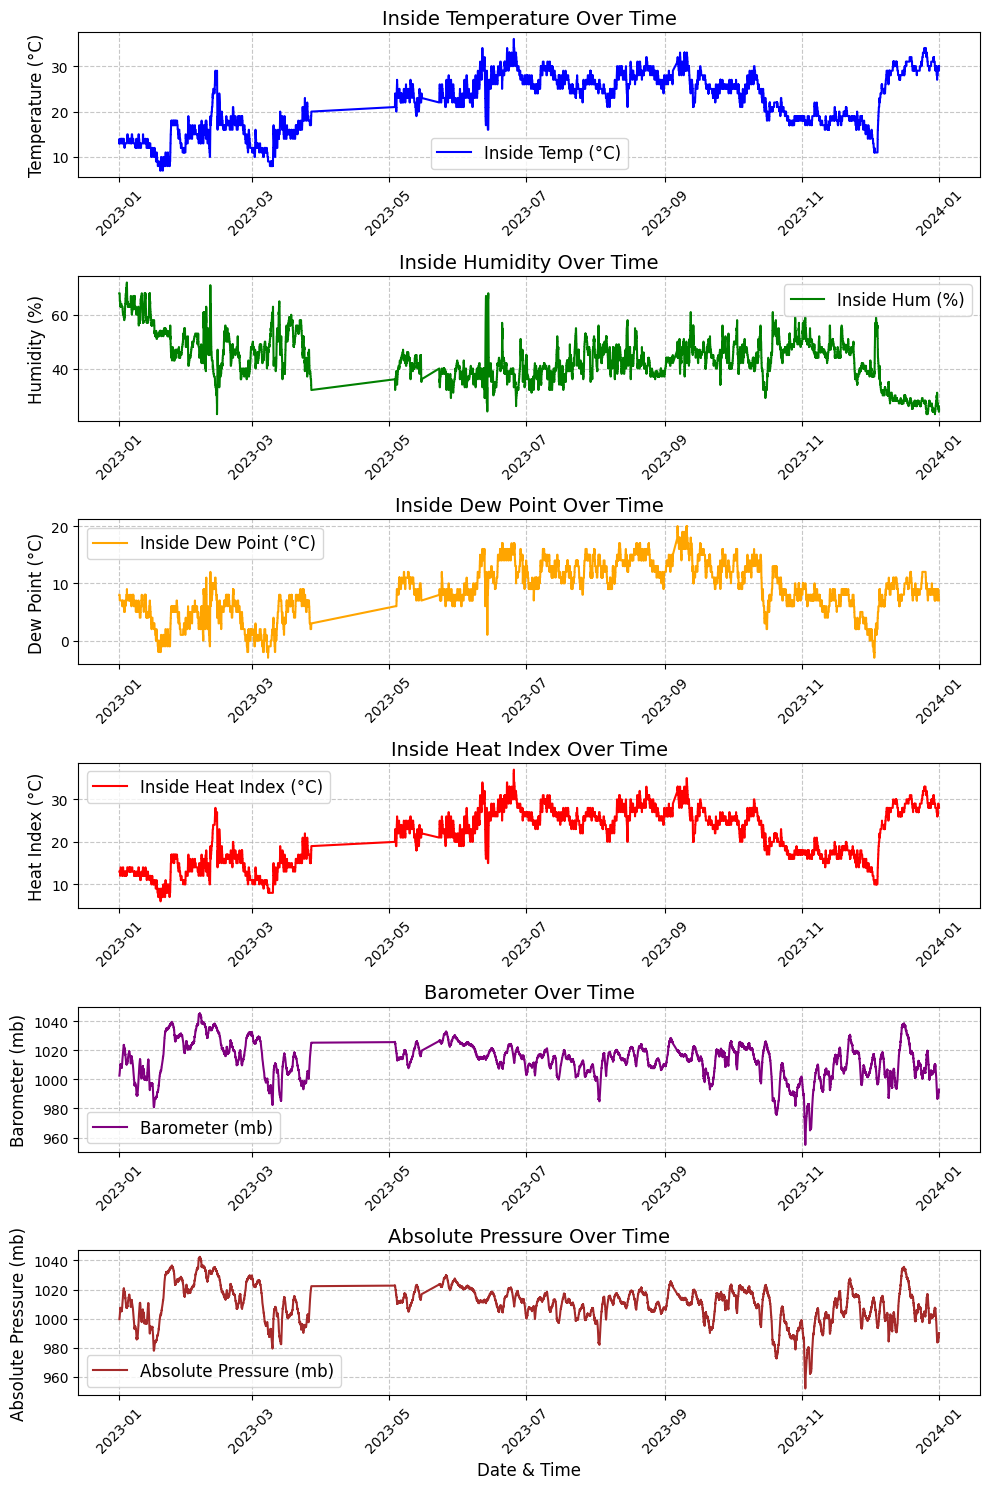

In [37]:
# Visualization for the Entire Dataset
fig, axes = plt.subplots(6, 1, figsize=(10, 15))

# Plot Inside Temperature
axes[0].plot(df_wLink_cleaned['Date & Time'], df_wLink_cleaned['Inside Temp - °C'], color='blue', label='Inside Temp (°C)')
axes[0].set_title('Inside Temperature Over Time', fontsize=14)
axes[0].set_ylabel('Temperature (°C)', fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].legend(fontsize=12)

# Plot Inside Humidity
axes[1].plot(df_wLink_cleaned['Date & Time'], df_wLink_cleaned['Inside Hum - %'], color='green', label='Inside Hum (%)')
axes[1].set_title('Inside Humidity Over Time', fontsize=14)
axes[1].set_ylabel('Humidity (%)', fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].legend(fontsize=12)

# Plot Inside Dew Point
axes[2].plot(df_wLink_cleaned['Date & Time'], df_wLink_cleaned['Inside Dew Point - °C'], color='orange', label='Inside Dew Point (°C)')
axes[2].set_title('Inside Dew Point Over Time', fontsize=14)
axes[2].set_ylabel('Dew Point (°C)', fontsize=12)
axes[2].grid(True, linestyle='--', alpha=0.7)
axes[2].legend(fontsize=12)

# Plot Inside Heat Index
axes[3].plot(df_wLink_cleaned['Date & Time'], df_wLink_cleaned['Inside Heat Index - °C'], color='red', label='Inside Heat Index (°C)')
axes[3].set_title('Inside Heat Index Over Time', fontsize=14)
axes[3].set_ylabel('Heat Index (°C)', fontsize=12)
axes[3].grid(True, linestyle='--', alpha=0.7)
axes[3].legend(fontsize=12)

# Plot Barometer
axes[4].plot(df_wLink_cleaned['Date & Time'], df_wLink_cleaned['Barometer - mb'], color='purple', label='Barometer (mb)')
axes[4].set_title('Barometer Over Time', fontsize=14)
axes[4].set_ylabel('Barometer (mb)', fontsize=12)
axes[4].grid(True, linestyle='--', alpha=0.7)
axes[4].legend(fontsize=12)

# Plot Absolute Pressure
axes[5].plot(df_wLink_cleaned['Date & Time'], df_wLink_cleaned['Absolute Pressure - mb'], color='brown', label='Absolute Pressure (mb)')
axes[5].set_title('Absolute Pressure Over Time', fontsize=14)
axes[5].set_xlabel('Date & Time', fontsize=12)
axes[5].set_ylabel('Absolute Pressure (mb)', fontsize=12)
axes[5].grid(True, linestyle='--', alpha=0.7)
axes[5].legend(fontsize=12)

# Rotate x-axis labels for better readability
for ax in axes:
    ax.tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

In [38]:
# View Filtered Data (6-month range)
# Define the date range
start_date = '2023-07-01'
end_date = '2023-12-2'

# Filter the DataFrame
df_wLink_filtered  = df_wLink_cleaned[(df_wLink_cleaned['Date & Time'] >= start_date) & (df_wLink_cleaned['Date & Time'] <= end_date)]

# Check the filtered data
df_wLink_filtered .head()

Date & Time  Inside Temp - °C  Inside Hum - %  \
13026 2023-07-01 00:00:00                27              43   
13027 2023-07-01 00:15:00                27              43   
13028 2023-07-01 00:30:00                27              44   
13029 2023-07-01 00:45:00                27              44   
13030 2023-07-01 01:00:00                27              44   

       Inside Dew Point - °C  Inside Heat Index - °C  Barometer - mb  \
13026                     13                      26          1005.3   
13027                     13                      26          1005.1   
13028                     13                      26          1005.0   
13029                     13                      26          1004.8   
13030                     13                      26          1004.8   

       Absolute Pressure - mb  Temp Range - °C  Humidity Range - %  \
13026                  1002.3                0                   1   
13027                  1002.2                0                   1   
13028                  1002.1                0                   1   
13029                  1001.8                0                   1   
13030                  1001.8                0                   0   

       Pressure Range - mb  
13026                  0.0  
13027                  0.3  
13028                  0.2  
13029                  0.2  
13030                  0.2

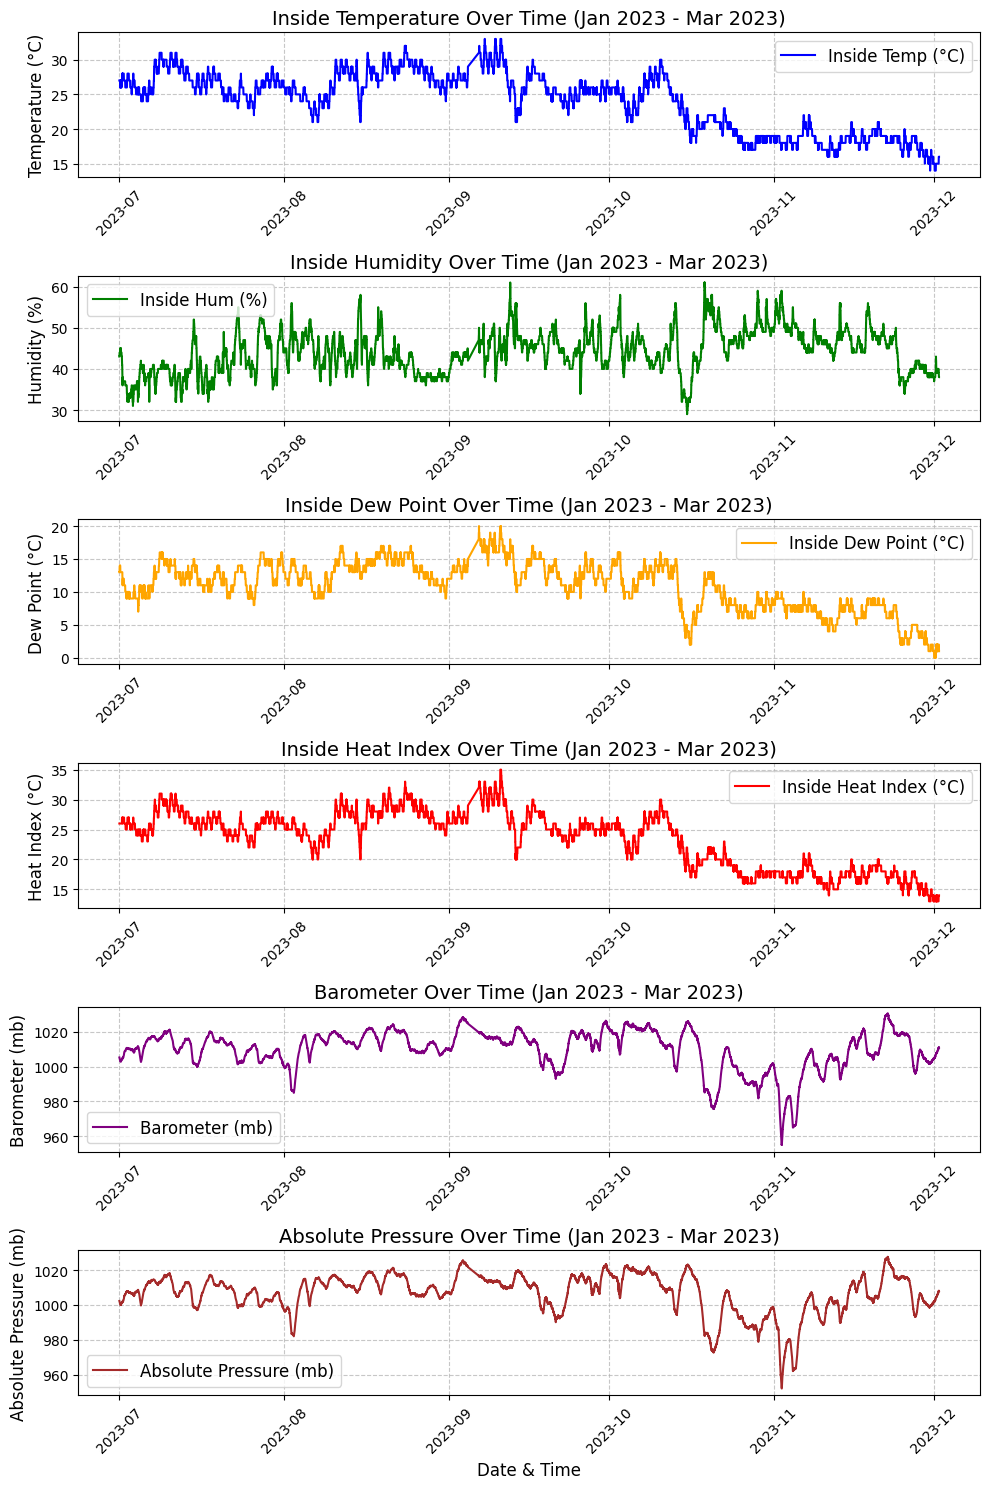

In [39]:
# Create a figure with 6 subplots
fig, axes = plt.subplots(6, 1, figsize=(10, 15))

# Plot Inside Temperature
axes[0].plot(df_wLink_filtered['Date & Time'], df_wLink_filtered['Inside Temp - °C'], color='blue', label='Inside Temp (°C)')
axes[0].set_title('Inside Temperature Over Time (Jan 2023 - Mar 2023)', fontsize=14)
axes[0].set_ylabel('Temperature (°C)', fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].legend(fontsize=12)

# Plot Inside Humidity
axes[1].plot(df_wLink_filtered['Date & Time'], df_wLink_filtered['Inside Hum - %'], color='green', label='Inside Hum (%)')
axes[1].set_title('Inside Humidity Over Time (Jan 2023 - Mar 2023)', fontsize=14)
axes[1].set_ylabel('Humidity (%)', fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].legend(fontsize=12)

# Plot Inside Dew Point
axes[2].plot(df_wLink_filtered['Date & Time'], df_wLink_filtered['Inside Dew Point - °C'], color='orange', label='Inside Dew Point (°C)')
axes[2].set_title('Inside Dew Point Over Time (Jan 2023 - Mar 2023)', fontsize=14)
axes[2].set_ylabel('Dew Point (°C)', fontsize=12)
axes[2].grid(True, linestyle='--', alpha=0.7)
axes[2].legend(fontsize=12)

# Plot Inside Heat Index
axes[3].plot(df_wLink_filtered['Date & Time'], df_wLink_filtered['Inside Heat Index - °C'], color='red', label='Inside Heat Index (°C)')
axes[3].set_title('Inside Heat Index Over Time (Jan 2023 - Mar 2023)', fontsize=14)
axes[3].set_ylabel('Heat Index (°C)', fontsize=12)
axes[3].grid(True, linestyle='--', alpha=0.7)
axes[3].legend(fontsize=12)

# Plot Barometer
axes[4].plot(df_wLink_filtered['Date & Time'], df_wLink_filtered['Barometer - mb'], color='purple', label='Barometer (mb)')
axes[4].set_title('Barometer Over Time (Jan 2023 - Mar 2023)', fontsize=14)
axes[4].set_ylabel('Barometer (mb)', fontsize=12)
axes[4].grid(True, linestyle='--', alpha=0.7)
axes[4].legend(fontsize=12)

# Plot Absolute Pressure
axes[5].plot(df_wLink_filtered['Date & Time'], df_wLink_filtered['Absolute Pressure - mb'], color='brown', label='Absolute Pressure (mb)')
axes[5].set_title('Absolute Pressure Over Time (Jan 2023 - Mar 2023)', fontsize=14)
axes[5].set_xlabel('Date & Time', fontsize=12)
axes[5].set_ylabel('Absolute Pressure (mb)', fontsize=12)
axes[5].grid(True, linestyle='--', alpha=0.7)
axes[5].legend(fontsize=12)

# Rotate x-axis labels for better readability
for ax in axes:
    ax.tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

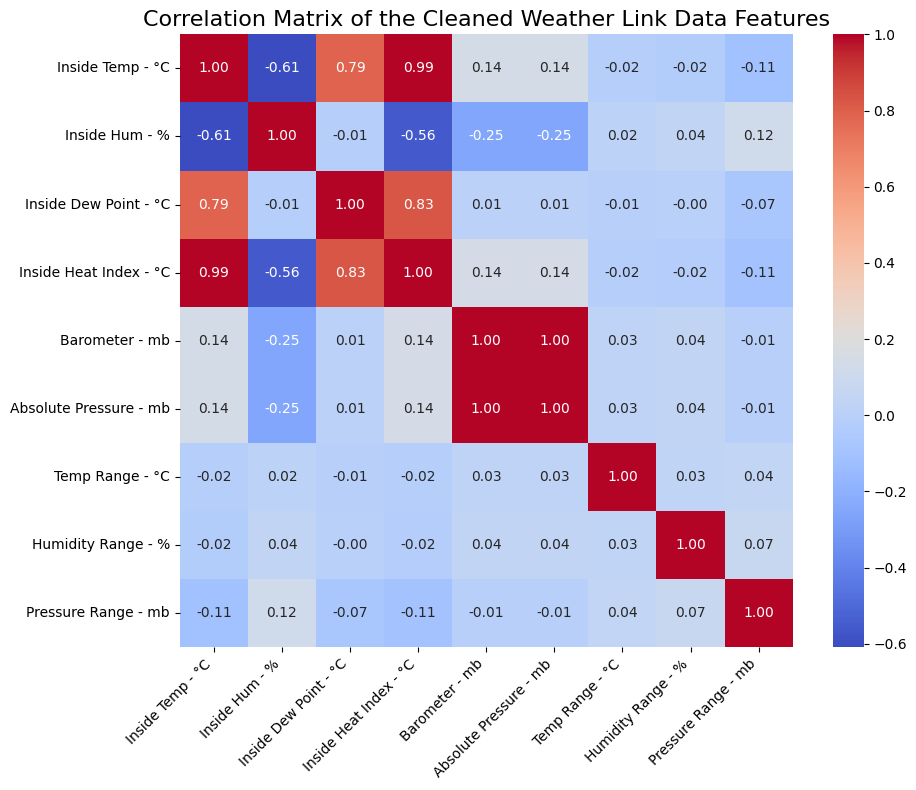

In [40]:
# Calculate correlation matrix for filtered data
correlation_matrix = df_wLink_cleaned.drop(columns=["Date & Time"]).corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Correlation Matrix of the Cleaned Weather Link Data Features", fontsize=16)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

*The correlation matrix shows that Inside Temp - °C, Inside Heat Index - °C, and Inside Dew Point - °C are strongly correlated, indicating these features are interrelated and may provide redundant information. Inside Hum - % is negatively correlated with temperature and heat index, reflecting the inverse relationship between temperature and relative humidity. Barometer - mb and Absolute Pressure - mb are perfectly correlated, while features like Pressure Range - mb and Temp Range - °C exhibit weak correlations with most variables, suggesting limited predictive value.*

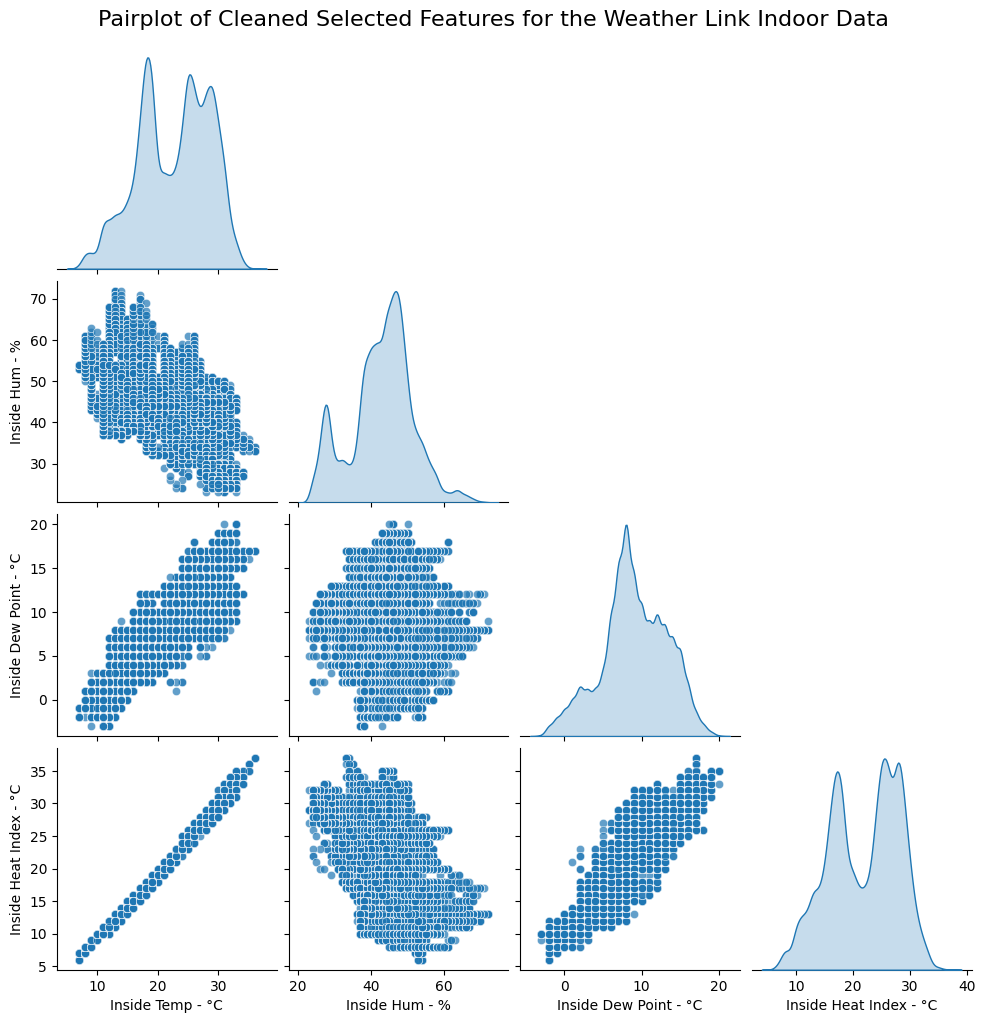

In [41]:
# Pairplot for selected features to visualize relationships
selected_features = [
    "Inside Temp - °C", "Inside Hum - %",
    "Inside Dew Point - °C", "Inside Heat Index - °C"
]
sns.pairplot(df_wLink_cleaned[selected_features], diag_kind="kde", corner=True, plot_kws={"alpha": 0.7})
plt.suptitle("Pairplot of Cleaned Selected Features for the Weather Link Indoor Data", y=1.02, fontsize=16)
plt.show()

*Inside Temp (°C) and Inside Heat Index (°C) exhibit a nearly linear correlation, while Inside Humidity (%) shows an inverse pattern with temperature-related features. Distributions along the diagonal suggest Inside Heat Index (°C) and Inside Humidity (%) have bimodal characteristics, which may point to distinct environmental states captured during the data period.*

*Saved Clean Version of Weather Link Indoor Data to Use for Model Predictions*

In [42]:
# Define the output directory and file path
output_dir = "./data"
os.makedirs(output_dir, exist_ok=True)
cleaned_df3 = os.path.join(output_dir, "Weather Link Indoor Cleaned.csv")

# Save the cleaned dataframe to a CSV file
df_wLink_cleaned.to_csv(cleaned_df3, index=False)

cleaned_df3

'./data/Weather Link Indoor Cleaned.csv'

## Combined Dataset

In [43]:
# Add the 'Sensor' column permanently to df_wLink_cleaned
df_wLink_cleaned['Sensor'] = 'WeatherLink'

# Drop the specified columns from df_wLink_cleaned
columns_to_remove = ["Absolute Pressure - mb", "Temp Range - °C", "Humidity Range - %", "Pressure Range - mb"]
df_wLink_cleaned.drop(columns=columns_to_remove, inplace=True)

df_wLink_cleaned.head()

Date & Time  Inside Temp - °C  Inside Hum - %  \
0 2023-01-01 00:00:00                13              68   
1 2023-01-01 00:15:00                13              68   
2 2023-01-01 00:30:00                13              68   
3 2023-01-01 00:45:00                13              68   
4 2023-01-01 01:00:00                13              68   

   Inside Dew Point - °C  Inside Heat Index - °C  Barometer - mb       Sensor  
0                      8                      13          1002.6  WeatherLink  
1                      8                      13          1002.7  WeatherLink  
2                      8                      13          1002.6  WeatherLink  
3                      8                      13          1002.7  WeatherLink  
4                      8                      13          1002.7  WeatherLink

In [44]:
df_wLink_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52864 entries, 0 to 52863
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date & Time             52864 non-null  datetime64[ns]
 1   Inside Temp - °C        52864 non-null  int64         
 2   Inside Hum - %          52864 non-null  int64         
 3   Inside Dew Point - °C   52864 non-null  int64         
 4   Inside Heat Index - °C  52864 non-null  int64         
 5   Barometer - mb          52864 non-null  float64       
 6   Sensor                  52864 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 2.8+ MB


In [45]:
df2_clean.head()

Sensor            DateTime  Value Unit
0  EcoLab Ground (CO107) 2022-12-31 23:53:24  518.0  ppm
1   EcoLab Ground (H107) 2022-12-31 23:53:24   73.0  %RH
2   EcoLab Ground (T107) 2022-12-31 23:53:24   12.3   °C
3  EcoLab Ground (CO107) 2023-01-01 00:00:55  520.0  ppm
4   EcoLab Ground (H107) 2023-01-01 00:00:55   73.0  %RH

In [46]:
# Change all values in the "Sensor" column to "EcoLab Ground"
df2_clean["Sensor"] = "EcoLab Ground"

# Confirm the update
print(df2_clean["Sensor"].unique())  # Verify that all values are now "EcoLab Ground"

['EcoLab Ground']


In [47]:
# Step 1: Preserve 'Sensor' by taking the first occurrence per DateTime
df2_clean_sensor = df2_clean[["DateTime", "Sensor"]].drop_duplicates(subset="DateTime")

# Step 2: Aggregate duplicate values using mean (or max, min, etc.)
df2_clean = df2_clean.groupby(["DateTime", "Unit"], as_index=False)["Value"].mean()

# Step 3: Pivot the cleaned dataframe
df2_clean = df2_clean.pivot(index="DateTime", columns="Unit", values="Value").reset_index()

# Step 4: Rename columns for clarity
df2_clean.rename(columns={"ppm": "eCO₂ (ppm)", "%RH": "RH (%)", "°C": "Inside Temp - °C"}, inplace=True)

# Step 5: Merge 'Sensor' column back into df2_clean
df2_clean = df2_clean.merge(df2_clean_sensor, on="DateTime", how="left")

In [48]:
df2_clean.head()

DateTime  RH (%)  eCO₂ (ppm)  Inside Temp - °C         Sensor
0 2022-12-31 23:53:24    73.0       518.0              12.3  EcoLab Ground
1 2023-01-01 00:00:55    73.0       520.0              12.4  EcoLab Ground
2 2023-01-01 00:08:23    73.0       505.0              12.4  EcoLab Ground
3 2023-01-01 00:15:52    73.0       491.0              12.4  EcoLab Ground
4 2023-01-01 00:23:22    73.0       509.0              12.4  EcoLab Ground

In [49]:
df2_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59892 entries, 0 to 59891
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   DateTime          59892 non-null  datetime64[ns]
 1   RH (%)            59892 non-null  float64       
 2   eCO₂ (ppm)        59892 non-null  float64       
 3   Inside Temp - °C  59892 non-null  float64       
 4   Sensor            59892 non-null  object        
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 2.3+ MB


In [50]:
invisible = df2_clean.copy()
weatherlink = df_wLink_cleaned.copy()

In [51]:
# Rename 'Date & Time' in weatherlink to match 'DateTime' in invisible
weatherlink.rename(columns={"Date & Time": "DateTime"}, inplace=True)

# Check for duplicate timestamps in both datasets
duplicates_invisible = invisible[invisible.duplicated(subset="DateTime", keep=False)]
duplicates_weatherlink = weatherlink[weatherlink.duplicated(subset="DateTime", keep=False)]

print(f"Duplicates in invisible: {len(duplicates_invisible)}")
print(f"Duplicates in weatherlink: {len(duplicates_weatherlink)}")

# Remove duplicate timestamps while keeping the first occurrence
invisible = invisible.drop_duplicates(subset="DateTime", keep="first")
weatherlink = weatherlink.drop_duplicates(subset="DateTime", keep="first")

# Merge on 'DateTime', keeping all timestamps (outer join)
df_combined = pd.merge(invisible, weatherlink, on="DateTime", how="outer", suffixes=("_invisible", "_weatherlink"))

# Handle "Inside Temp - °C" and "RH (%)" Columns
# If both exist, take the average; otherwise, keep the available value
df_combined["Inside Temp - °C"] = df_combined[["Inside Temp - °C_invisible", "Inside Temp - °C_weatherlink"]].mean(axis=1)
df_combined["RH (%)"] = df_combined[["RH (%)", "Inside Hum - %"]].mean(axis=1)

# Keep only one "Sensor" column
df_combined["Sensor"] = df_combined["Sensor_invisible"].fillna(df_combined["Sensor_weatherlink"])

# Drop the old column names after merging
df_combined.drop(columns=[
    "Inside Temp - °C_invisible", "Inside Temp - °C_weatherlink",
    "Inside Hum - %", "Sensor_invisible", "Sensor_weatherlink"
], inplace=True)

# Confirm the merge structure
print(df_combined.info())  # Check structure

Duplicates in invisible: 0
Duplicates in weatherlink: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112622 entries, 0 to 112621
Data columns (total 8 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   DateTime                112622 non-null  datetime64[ns]
 1   RH (%)                  112622 non-null  float64       
 2   eCO₂ (ppm)              59892 non-null   float64       
 3   Inside Dew Point - °C   52864 non-null   float64       
 4   Inside Heat Index - °C  52864 non-null   float64       
 5   Barometer - mb          52864 non-null   float64       
 6   Inside Temp - °C        112622 non-null  float64       
 7   Sensor                  112622 non-null  object        
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 6.9+ MB
None


In [52]:
df_combined.head()

DateTime  RH (%)  eCO₂ (ppm)  Inside Dew Point - °C  \
0 2022-12-31 23:53:24    73.0       518.0                    NaN   
1 2023-01-01 00:00:00    68.0         NaN                    8.0   
2 2023-01-01 00:00:55    73.0       520.0                    NaN   
3 2023-01-01 00:08:23    73.0       505.0                    NaN   
4 2023-01-01 00:15:00    68.0         NaN                    8.0   

   Inside Heat Index - °C  Barometer - mb  Inside Temp - °C         Sensor  
0                     NaN             NaN              12.3  EcoLab Ground  
1                    13.0          1002.6              13.0    WeatherLink  
2                     NaN             NaN              12.4  EcoLab Ground  
3                     NaN             NaN              12.4  EcoLab Ground  
4                    13.0          1002.7              13.0    WeatherLink

In [53]:
# Fill missing Dew Point values using the formula
df_combined["Inside Dew Point - °C"] = df_combined["Inside Dew Point - °C"].fillna(
    df_combined["Inside Temp - °C"] - ((100 - df_combined["RH (%)"]) / 5)
)

# Confirm the changes
print("Remaining missing heat index: ", df_combined["Inside Dew Point - °C"].isna().sum())  # Count remaining NaN values

Remaining missing heat index:  0


In [54]:
df_combined.head()

DateTime  RH (%)  eCO₂ (ppm)  Inside Dew Point - °C  \
0 2022-12-31 23:53:24    73.0       518.0                    6.9   
1 2023-01-01 00:00:00    68.0         NaN                    8.0   
2 2023-01-01 00:00:55    73.0       520.0                    7.0   
3 2023-01-01 00:08:23    73.0       505.0                    7.0   
4 2023-01-01 00:15:00    68.0         NaN                    8.0   

   Inside Heat Index - °C  Barometer - mb  Inside Temp - °C         Sensor  
0                     NaN             NaN              12.3  EcoLab Ground  
1                    13.0          1002.6              13.0    WeatherLink  
2                     NaN             NaN              12.4  EcoLab Ground  
3                     NaN             NaN              12.4  EcoLab Ground  
4                    13.0          1002.7              13.0    WeatherLink

In [55]:
# Ensure Temperature and RH are available before applying the formula
if "Inside Temp - °C" in df_combined.columns and "RH (%)" in df_combined.columns:
    T_C = df_combined["Inside Temp - °C"]
    RH = df_combined["RH (%)"]

    # Convert Celsius to Fahrenheit
    T_F = (T_C * 9/5) + 32

    # Identify missing values in Heat Index column
    missing_HI_mask = df_combined["Inside Heat Index - °C"].isna()

    # Apply the Heat Index formula only if T_F >= 80.6°F (27°C) AND it's missing
    mask = (T_F >= 80.6) & missing_HI_mask

    HI_F = np.where(mask,
        -42.379 + (2.04901523 * T_F) + (10.14333127 * RH) - (0.22475541 * T_F * RH)
        - (0.00683783 * T_F**2) - (0.05481717 * RH**2) + (0.00122874 * T_F**2 * RH)
        + (0.00085282 * T_F * RH**2) - (0.00000199 * T_F**2 * RH**2),
        T_F  # If T < 27°C or value is already filled, use actual temperature in Fahrenheit
    )

    # Convert Heat Index back to Celsius
    HI_C = (HI_F - 32) * 5/9

    # Fill missing Heat Index values only
    df_combined.loc[missing_HI_mask, "Inside Heat Index - °C"] = HI_C[missing_HI_mask]

# Confirm the changes
print("Remaining missing heat index: ", df_combined["Inside Heat Index - °C"].isna().sum())  # Count remaining NaN values

Remaining missing heat index:  0


In [56]:
# Ensure data is sorted by DateTime
df_combined = df_combined.sort_values("DateTime")

# Apply forward-fill and backward-fill correctly
df_combined["Barometer - mb"] = df_combined["Barometer - mb"].ffill().bfill()

# Confirm changes
print("Remaining missing Barometer values:", df_combined["Barometer - mb"].isna().sum())

Remaining missing Barometer values: 0


In [57]:
# Ensure data is sorted by DateTime
df_combined = df_combined.sort_values("DateTime")

# Apply forward-fill and backward-fill correctly
df_combined["eCO₂ (ppm)"] = df_combined["eCO₂ (ppm)"].ffill().bfill()

# Confirm changes
print("Remaining missing eCO₂ values:", df_combined["eCO₂ (ppm)"].isna().sum())

Remaining missing eCO₂ values: 0


In [58]:
df_combined.head(20)

DateTime  RH (%)  eCO₂ (ppm)  Inside Dew Point - °C  \
0  2022-12-31 23:53:24    73.0       518.0                    6.9   
1  2023-01-01 00:00:00    68.0       518.0                    8.0   
2  2023-01-01 00:00:55    73.0       520.0                    7.0   
3  2023-01-01 00:08:23    73.0       505.0                    7.0   
4  2023-01-01 00:15:00    68.0       505.0                    8.0   
5  2023-01-01 00:15:52    73.0       491.0                    7.0   
6  2023-01-01 00:23:22    73.0       509.0                    7.0   
7  2023-01-01 00:30:00    68.0       509.0                    8.0   
8  2023-01-01 00:30:49    73.0       512.0                    7.0   
9  2023-01-01 00:38:18    73.0       507.0                    7.0   
10 2023-01-01 00:45:00    68.0       507.0                    8.0   
11 2023-01-01 00:45:50    73.0       516.0                    7.0   
12 2023-01-01 00:53:22    73.0       521.0                    7.0   
13 2023-01-01 01:00:00    68.0       521.0                    8.0   
14 2023-01-01 01:00:48    73.0       524.0                    7.0   
15 2023-01-01 01:08:19    73.0       533.0                    7.0   
16 2023-01-01 01:15:00    68.0       533.0                    8.0   
17 2023-01-01 01:15:52    73.0       539.0                    7.0   
18 2023-01-01 01:23:23    72.5       518.0                    6.9   
19 2023-01-01 01:30:00    68.0       518.0                    8.0   

    Inside Heat Index - °C  Barometer - mb  Inside Temp - °C         Sensor  
0                     12.3          1002.6              12.3  EcoLab Ground  
1                     13.0          1002.6              13.0    WeatherLink  
2                     12.4          1002.6              12.4  EcoLab Ground  
3                     12.4          1002.6              12.4  EcoLab Ground  
4                     13.0          1002.7              13.0    WeatherLink  
5                     12.4          1002.7              12.4  EcoLab Ground  
6                     12.4          1002.7              12.4  EcoLab Ground  
7                     13.0          1002.6              13.0    WeatherLink  
8                     12.4          1002.6              12.4  EcoLab Ground  
9                     12.4          1002.6              12.4  EcoLab Ground  
10                    13.0          1002.7              13.0    WeatherLink  
11                    12.4          1002.7              12.4  EcoLab Ground  
12                    12.4          1002.7              12.4  EcoLab Ground  
13                    13.0          1002.7              13.0    WeatherLink  
14                    12.4          1002.7              12.4  EcoLab Ground  
15                    12.4          1002.7              12.4  EcoLab Ground  
16                    13.0          1003.0              13.0    WeatherLink  
17                    12.4          1003.0              12.4  EcoLab Ground  
18                    12.4          1003.0              12.4  EcoLab Ground  
19                    13.0          1003.0              13.0    WeatherLink

# EDA

### **Realistic and Unrealistic Ranges for Variables**

#### **1. RH (%) (Relative Humidity)**
- **Realistic Range:** 30% - 60%  
- **Unrealistic (Outliers):** Below 10% or above 90%  
- **Why?** Indoor environments typically maintain humidity within this range for comfort and health. Values too high indicate excessive moisture, while too low may cause dryness.

#### **2. eCO₂ (ppm) (Equivalent Carbon Dioxide)**
- **Realistic Range:** 400 - 1,200 ppm  
- **Unrealistic (Outliers):** Below 300 ppm or above 3,000 ppm  
- **Why?** Normal indoor CO₂ levels typically range up to 1,200 ppm. Higher levels may indicate poor ventilation, while values below 300 ppm are unlikely indoors.

#### **3. Inside Dew Point (°C)**
- **Realistic Range:** 0°C - 20°C  
- **Unrealistic (Outliers):** Below -5°C or above 25°C  
- **Why?** The dew point is usually lower than room temperature and follows humidity. Extremely high values indicate excessive moisture, while very low values suggest overly dry air.

#### **4. Inside Heat Index (°C)**
- **Realistic Range:** 15°C - 35°C  
- **Unrealistic (Outliers):** Below 10°C or above 40°C  
- **Why?** The heat index factors in humidity and temperature. Indoors, it should align with comfort levels unless conditions are extreme.

#### **5. Barometer (mb)**
- **Realistic Range:** 980 - 1,040 mb  
- **Unrealistic (Outliers):** Below 960 mb or above 1,050 mb  
- **Why?** Atmospheric pressure typically stays in this range. Sudden extreme shifts may indicate sensor errors or extreme weather influences.

#### **6. Inside Temp (°C)**
- **Realistic Range:** 10°C - 35°C  
- **Unrealistic (Outliers):** Below 5°C or above 60°C  
- **Why?** Indoor temperatures are typically kept in this range for comfort. Anything lower or higher is rare in a controlled indoor setting.


In [59]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112622 entries, 0 to 112621
Data columns (total 8 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   DateTime                112622 non-null  datetime64[ns]
 1   RH (%)                  112622 non-null  float64       
 2   eCO₂ (ppm)              112622 non-null  float64       
 3   Inside Dew Point - °C   112622 non-null  float64       
 4   Inside Heat Index - °C  112622 non-null  float64       
 5   Barometer - mb          112622 non-null  float64       
 6   Inside Temp - °C        112622 non-null  float64       
 7   Sensor                  112622 non-null  object        
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 6.9+ MB


In [60]:
df_combined.describe()

DateTime         RH (%)     eCO₂ (ppm)  \
count                         112622  112622.000000  112622.000000   
mean   2023-07-21 00:41:37.414617344      47.337365     556.338131   
min              2022-12-31 23:53:24      23.000000     341.000000   
25%    2023-04-22 08:40:47.249999872      42.000000     474.000000   
50%       2023-08-07 16:09:38.500000      48.000000     521.000000   
75%              2023-10-20 17:18:45      53.000000     616.000000   
max              2024-01-01 00:00:00      81.500000    1509.000000   
std                              NaN       8.765766     113.047341   

       Inside Dew Point - °C  Inside Heat Index - °C  Barometer - mb  \
count          112622.000000           112622.000000   112622.000000   
mean                9.548797               20.771110     1013.125986   
min                -3.000000                5.500000      954.900000   
25%                 6.700000               16.400000     1005.700000   
50%                 9.100000               21.000000     1014.900000   
75%                13.000000               25.400000     1021.800000   
max                22.600000               37.000000     1045.600000   
std                 4.630214                5.819673       12.745266   

       Inside Temp - °C  
count     112622.000000  
mean          21.119610  
min            5.500000  
25%           17.000000  
50%           21.200000  
75%           25.800000  
max           36.000000  
std            5.774532

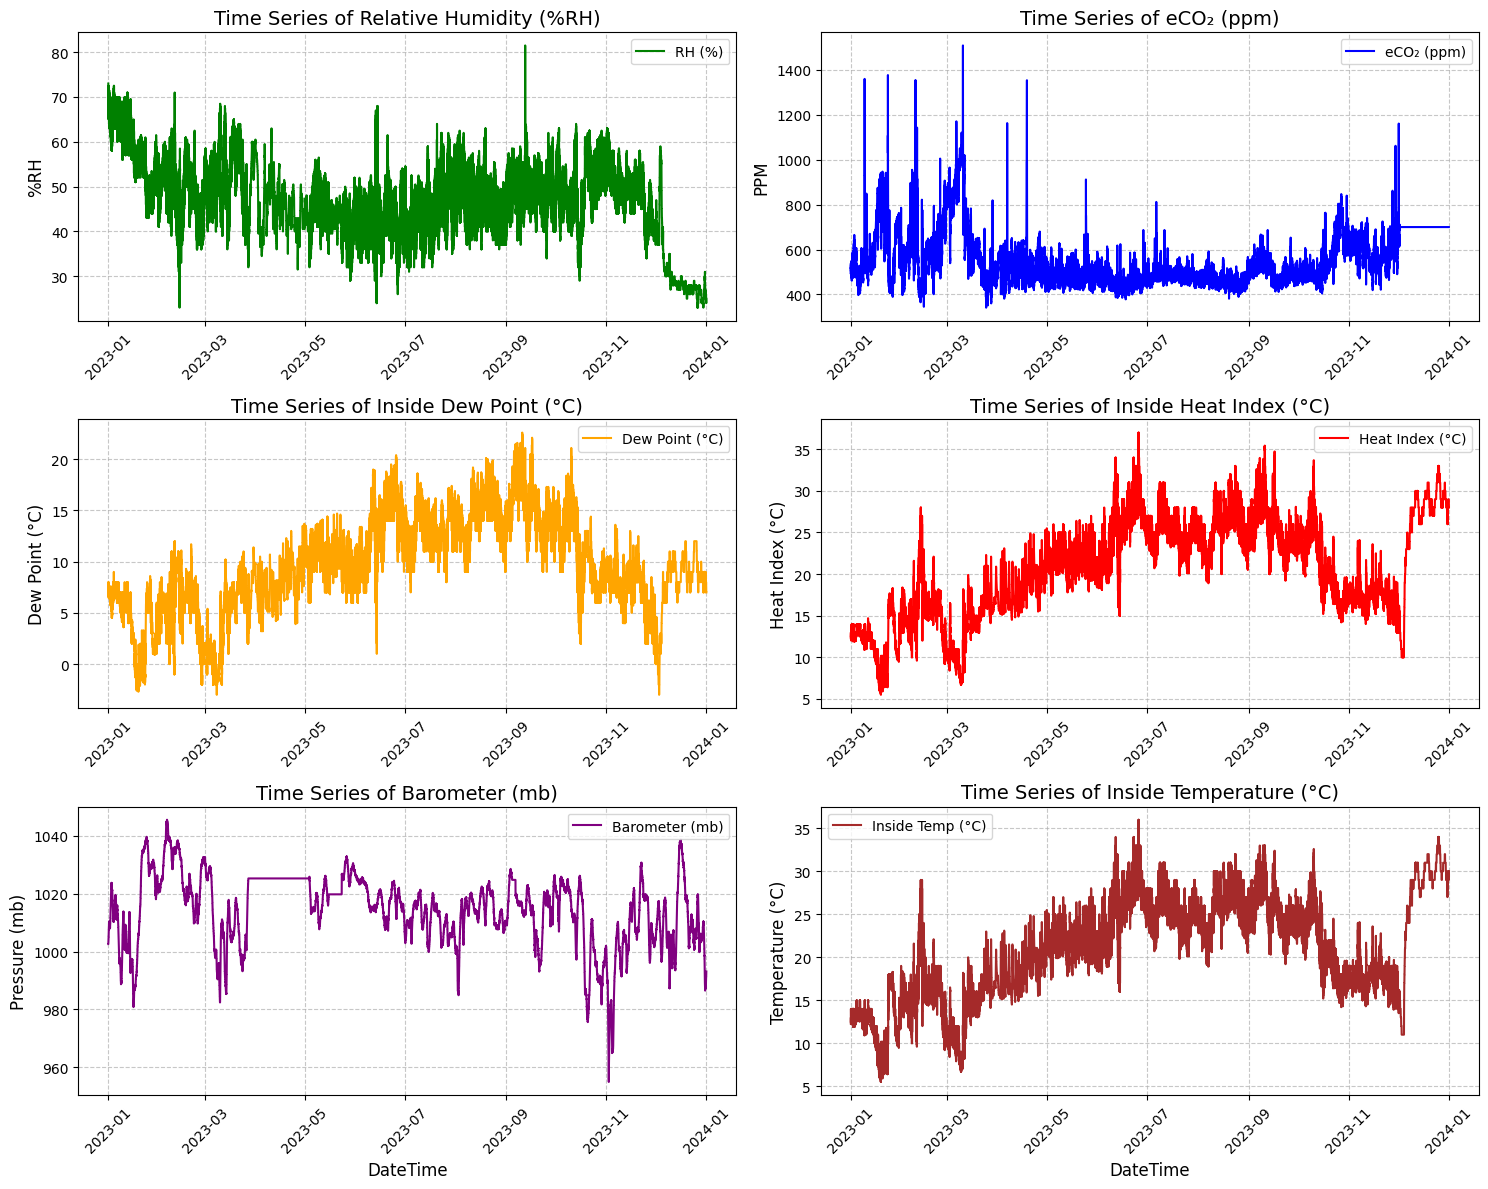

In [61]:
# Define figure and subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# Plot RH (%)
axes[0, 0].plot(df_combined["DateTime"], df_combined["RH (%)"], color="green", label="RH (%)")
axes[0, 0].set_title("Time Series of Relative Humidity (%RH)", fontsize=14)
axes[0, 0].set_ylabel("%RH", fontsize=12)
axes[0, 0].grid(True, linestyle="--", alpha=0.7)
axes[0, 0].legend(fontsize=10)

# Plot eCO₂ (ppm)
axes[0, 1].plot(df_combined["DateTime"], df_combined["eCO₂ (ppm)"], color="blue", label="eCO₂ (ppm)")
axes[0, 1].set_title("Time Series of eCO₂ (ppm)", fontsize=14)
axes[0, 1].set_ylabel("PPM", fontsize=12)
axes[0, 1].grid(True, linestyle="--", alpha=0.7)
axes[0, 1].legend(fontsize=10)

# Plot Inside Dew Point - °C
axes[1, 0].plot(df_combined["DateTime"], df_combined["Inside Dew Point - °C"], color="orange", label="Dew Point (°C)")
axes[1, 0].set_title("Time Series of Inside Dew Point (°C)", fontsize=14)
axes[1, 0].set_ylabel("Dew Point (°C)", fontsize=12)
axes[1, 0].grid(True, linestyle="--", alpha=0.7)
axes[1, 0].legend(fontsize=10)

# Plot Inside Heat Index - °C
axes[1, 1].plot(df_combined["DateTime"], df_combined["Inside Heat Index - °C"], color="red", label="Heat Index (°C)")
axes[1, 1].set_title("Time Series of Inside Heat Index (°C)", fontsize=14)
axes[1, 1].set_ylabel("Heat Index (°C)", fontsize=12)
axes[1, 1].grid(True, linestyle="--", alpha=0.7)
axes[1, 1].legend(fontsize=10)

# Plot Barometer - mb
axes[2, 0].plot(df_combined["DateTime"], df_combined["Barometer - mb"], color="purple", label="Barometer (mb)")
axes[2, 0].set_title("Time Series of Barometer (mb)", fontsize=14)
axes[2, 0].set_xlabel("DateTime", fontsize=12)
axes[2, 0].set_ylabel("Pressure (mb)", fontsize=12)
axes[2, 0].grid(True, linestyle="--", alpha=0.7)
axes[2, 0].legend(fontsize=10)

# Plot Inside Temp - °C
axes[2, 1].plot(df_combined["DateTime"], df_combined["Inside Temp - °C"], color="brown", label="Inside Temp (°C)")
axes[2, 1].set_title("Time Series of Inside Temperature (°C)", fontsize=14)
axes[2, 1].set_xlabel("DateTime", fontsize=12)
axes[2, 1].set_ylabel("Temperature (°C)", fontsize=12)
axes[2, 1].grid(True, linestyle="--", alpha=0.7)
axes[2, 1].legend(fontsize=10)

# Adjust x-axis labels for better readability
for ax in axes.flat:
    ax.tick_params(axis="x", rotation=45)

# Adjust layout for clarity
plt.tight_layout()
plt.show()

*The time-series plots provide insights into the variations of different indoor environmental factors over the course of a year. Relative Humidity (%RH) shows a declining trend, starting high at the beginning of the year and gradually decreasing, particularly after mid-year. eCO₂ (ppm) exhibits noticeable fluctuations, with spikes in the early months and another sharp increase towards the end of the year (December) as well as the immediate flatline, which may indicate sensor anomalies or environmental changes. Dew Point (°C) follows a seasonal trend, peaking around mid-year and declining towards winter, consistent with temperature changes. Inside Heat Index (°C) and Inside Temperature (°C) both exhibit an upward trend throughout the year, peaking around the summer months and then gradually decreasing. The Barometer (mb) shows a generally stable pattern but has a noticeable discontinuity or missing values around March, suggesting potential gaps in data collection. Lastly, the eCO₂ levels in December exhibit a significant increase, which may indicate a sensor issue or an environmental factor affecting indoor air quality. These anomalies warrant further investigation to determine their cause or to be discarded during AI modeling*

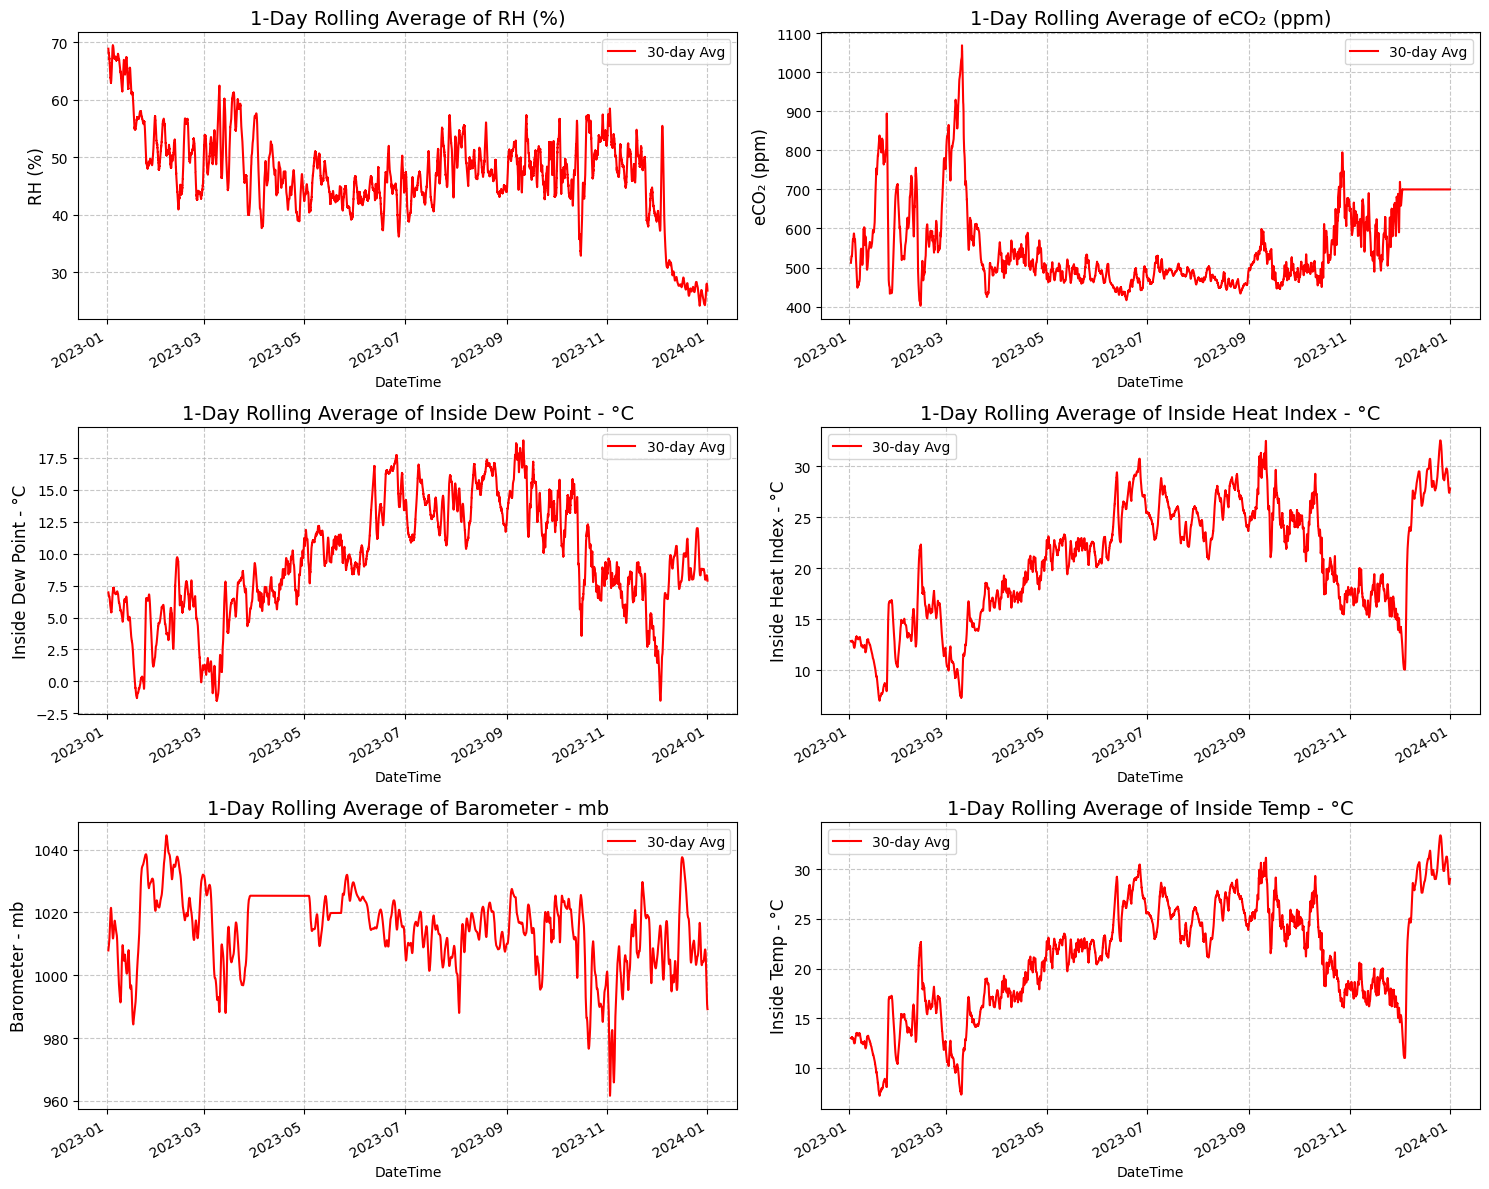

In [62]:
# Define variables for rolling average
variables = ["RH (%)", "eCO₂ (ppm)", "Inside Dew Point - °C", "Inside Heat Index - °C", "Barometer - mb", "Inside Temp - °C"]

# Define figure layout (3x2 grid)
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# Set rolling window size
# 6 data points = 30 min
# 12 data points =  1 hour
# 288 datapoints = 1 day
rolling_window = 288 # 1-day moving average

for i, var in enumerate(variables):
    ax = axes[i // 2, i % 2]

    # Plot rolling average for each variable
    df_combined.set_index("DateTime")[var].rolling(window=rolling_window).mean().plot(ax=ax, color="red", label="30-day Avg")

    ax.set_title(f"1-Day Rolling Average of {var}", fontsize=14)
    ax.set_ylabel(var, fontsize=12)
    ax.grid(True, linestyle="--", alpha=0.7)
    ax.legend(fontsize=10)

# Adjust layout for better readability
plt.tight_layout()
plt.show()

*The 1-day rolling averages provide a smoother representation of the trends observed in the original time-series data. Overall, the key patterns remain consistent, with Relative Humidity (%RH) showing a gradual decline throughout the year, Dew Point (°C) and Inside Heat Index (°C) peaking during the warmer months, and Inside Temperature (°C) following a similar seasonal trend. The rolling average helps reduce short-term fluctuations, making it easier to observe long-term trends. However, the Barometer (mb) still shows a discontinuity around March, confirming missing or inconsistent data. The eCO₂ (ppm) trend remains concerning, with a significant increase towards December, reinforcing the need for further investigation into potential sensor drift or environmental factors.*

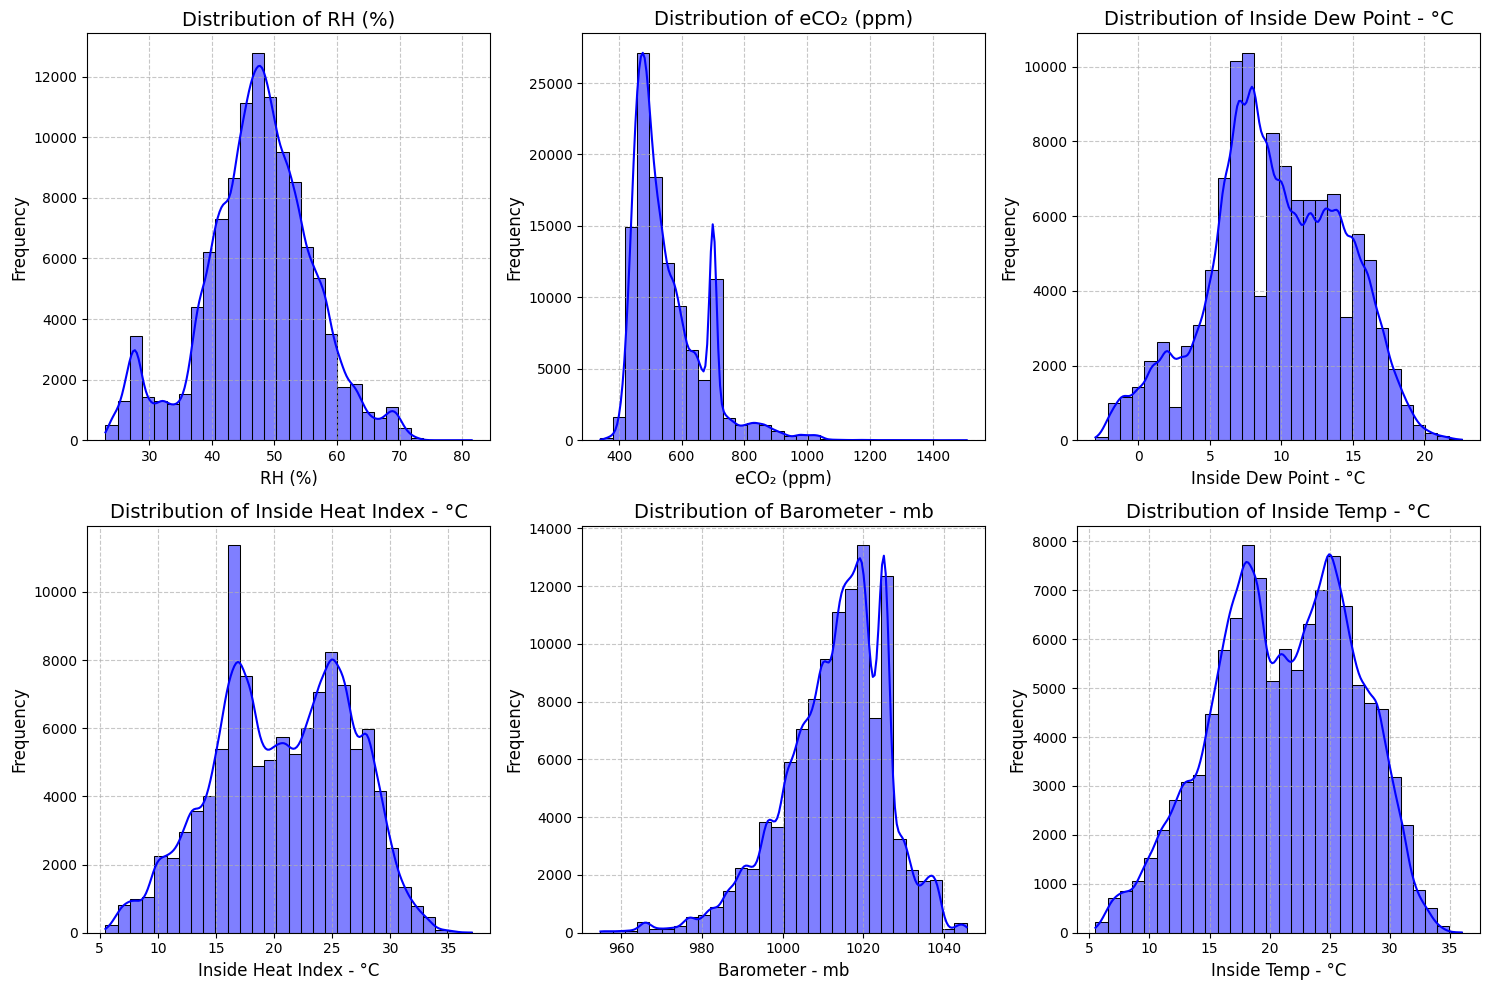

In [63]:
# Define variables to plot
variables = ["RH (%)", "eCO₂ (ppm)", "Inside Dew Point - °C", "Inside Heat Index - °C", "Barometer - mb", "Inside Temp - °C"]

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, var in enumerate(variables):
    ax = axes[i // 3, i % 3]  # Arrange in 2x3 grid
    sns.histplot(df_combined[var], kde=True, bins=30, ax=ax, color="blue")
    ax.set_title(f"Distribution of {var}", fontsize=14)
    ax.set_ylabel("Frequency", fontsize=12)
    ax.set_xlabel(var, fontsize=12)
    ax.grid(True, linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

*The histograms illustrate the distribution of key indoor environmental variables. Relative Humidity (%RH) is approximately normally distributed but shows a secondary peak at lower humidity levels, possibly indicating seasonal changes. eCO₂ (ppm) is right-skewed, with most values concentrated between 400-600 ppm, though there are some higher values suggesting periodic spikes. Inside Dew Point (°C) follows a normal distribution, peaking around 10°C, with some lower values indicating colder periods. Inside Heat Index (°C) exhibits a bimodal distribution, with peaks around 15°C and 25°C, suggesting seasonal variations. Barometer (mb) has an unusual pattern with two distinct peaks around 1015 mb and 1025 mb, reinforcing the earlier observation of possible sensor issues or abrupt environmental changes. Inside Temperature (°C) follows a bimodal pattern as well, with peaks around 15°C and 25°C, aligning with expected seasonal indoor climate variations. These distributions help identify potential anomalies and inform feature scaling or normalization strategies for modeling.*

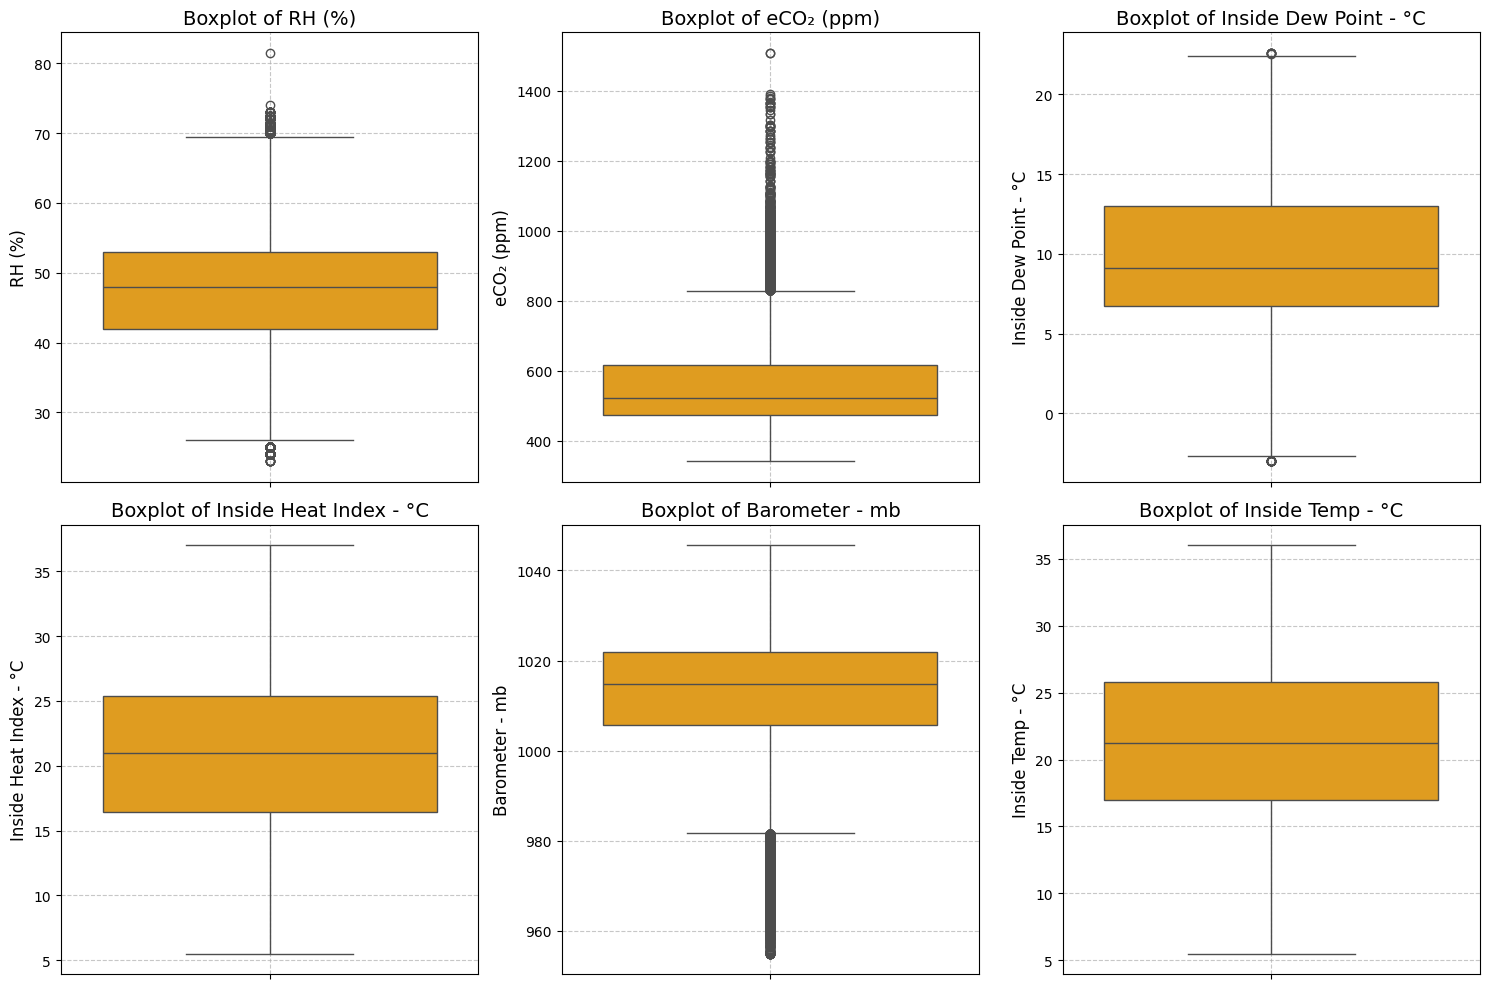

In [64]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, var in enumerate(variables):
    ax = axes[i // 3, i % 3]
    sns.boxplot(y=df_combined[var], ax=ax, color="orange")
    ax.set_title(f"Boxplot of {var}", fontsize=14)
    ax.set_ylabel(var, fontsize=12)
    ax.grid(True, linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

*The boxplots provide further confirmation of trends and anomalies observed in the previous visualizations. eCO₂ (ppm) has a significant number of outliers above 1000 ppm, reinforcing concerns about potential sensor inconsistencies or environmental fluctuations. Relative Humidity (%RH) also shows some lower-end outliers, which align with the declining trend seen earlier. Inside Dew Point (°C) and Inside Temperature (°C) follow expected seasonal variations, with moderate spread and fewer extreme outliers. Barometer (mb) again shows irregularities, particularly with lower-end outliers below 970 mb, which supports the discontinuity noted in previous analyses. These boxplots help highlight variability in the dataset and suggest areas where further cleaning or feature engineering may be necessary.*

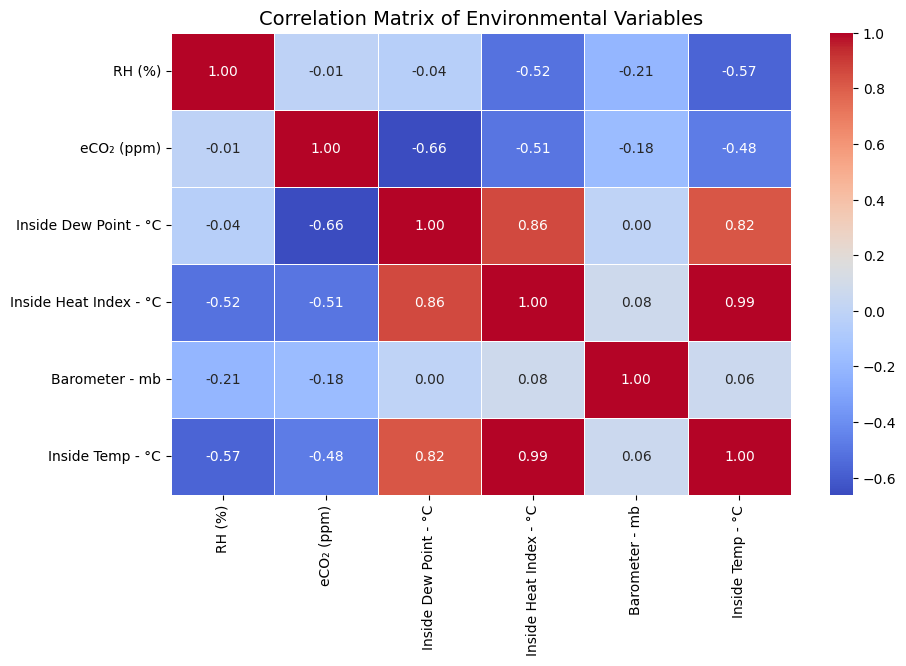

In [65]:
# Compute correlation matrix
corr_matrix = df_combined[variables].corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Environmental Variables", fontsize=14)
plt.show()

*The correlation matrix highlights key relationships between the environmental variables. Inside Temperature (°C) and Inside Heat Index (°C) are nearly perfectly correlated (0.99), which is expected since heat index is derived from temperature and humidity. Similarly, Inside Dew Point (°C) also has a strong positive correlation with Inside Temperature (0.82) and Heat Index (0.86), reinforcing the dependency of dew point on temperature.*

*eCO₂ (ppm) exhibits a notable negative correlation with Dew Point (-0.66), Heat Index (-0.51), and Inside Temperature (-0.48), suggesting that higher CO₂ levels might be associated with lower temperatures and humidity conditions indoors. Relative Humidity (RH) has a moderate negative correlation with Heat Index (-0.52) and Inside Temperature (-0.57), which makes sense as higher temperatures generally lower relative humidity.*

*Interestingly, Barometer (mb) shows very weak correlations with all variables, reinforcing previous concerns that its variations may be less influential in indoor environmental changes. This suggests that barometric pressure may not be a significant predictor of indoor air quality or temperature trends.*

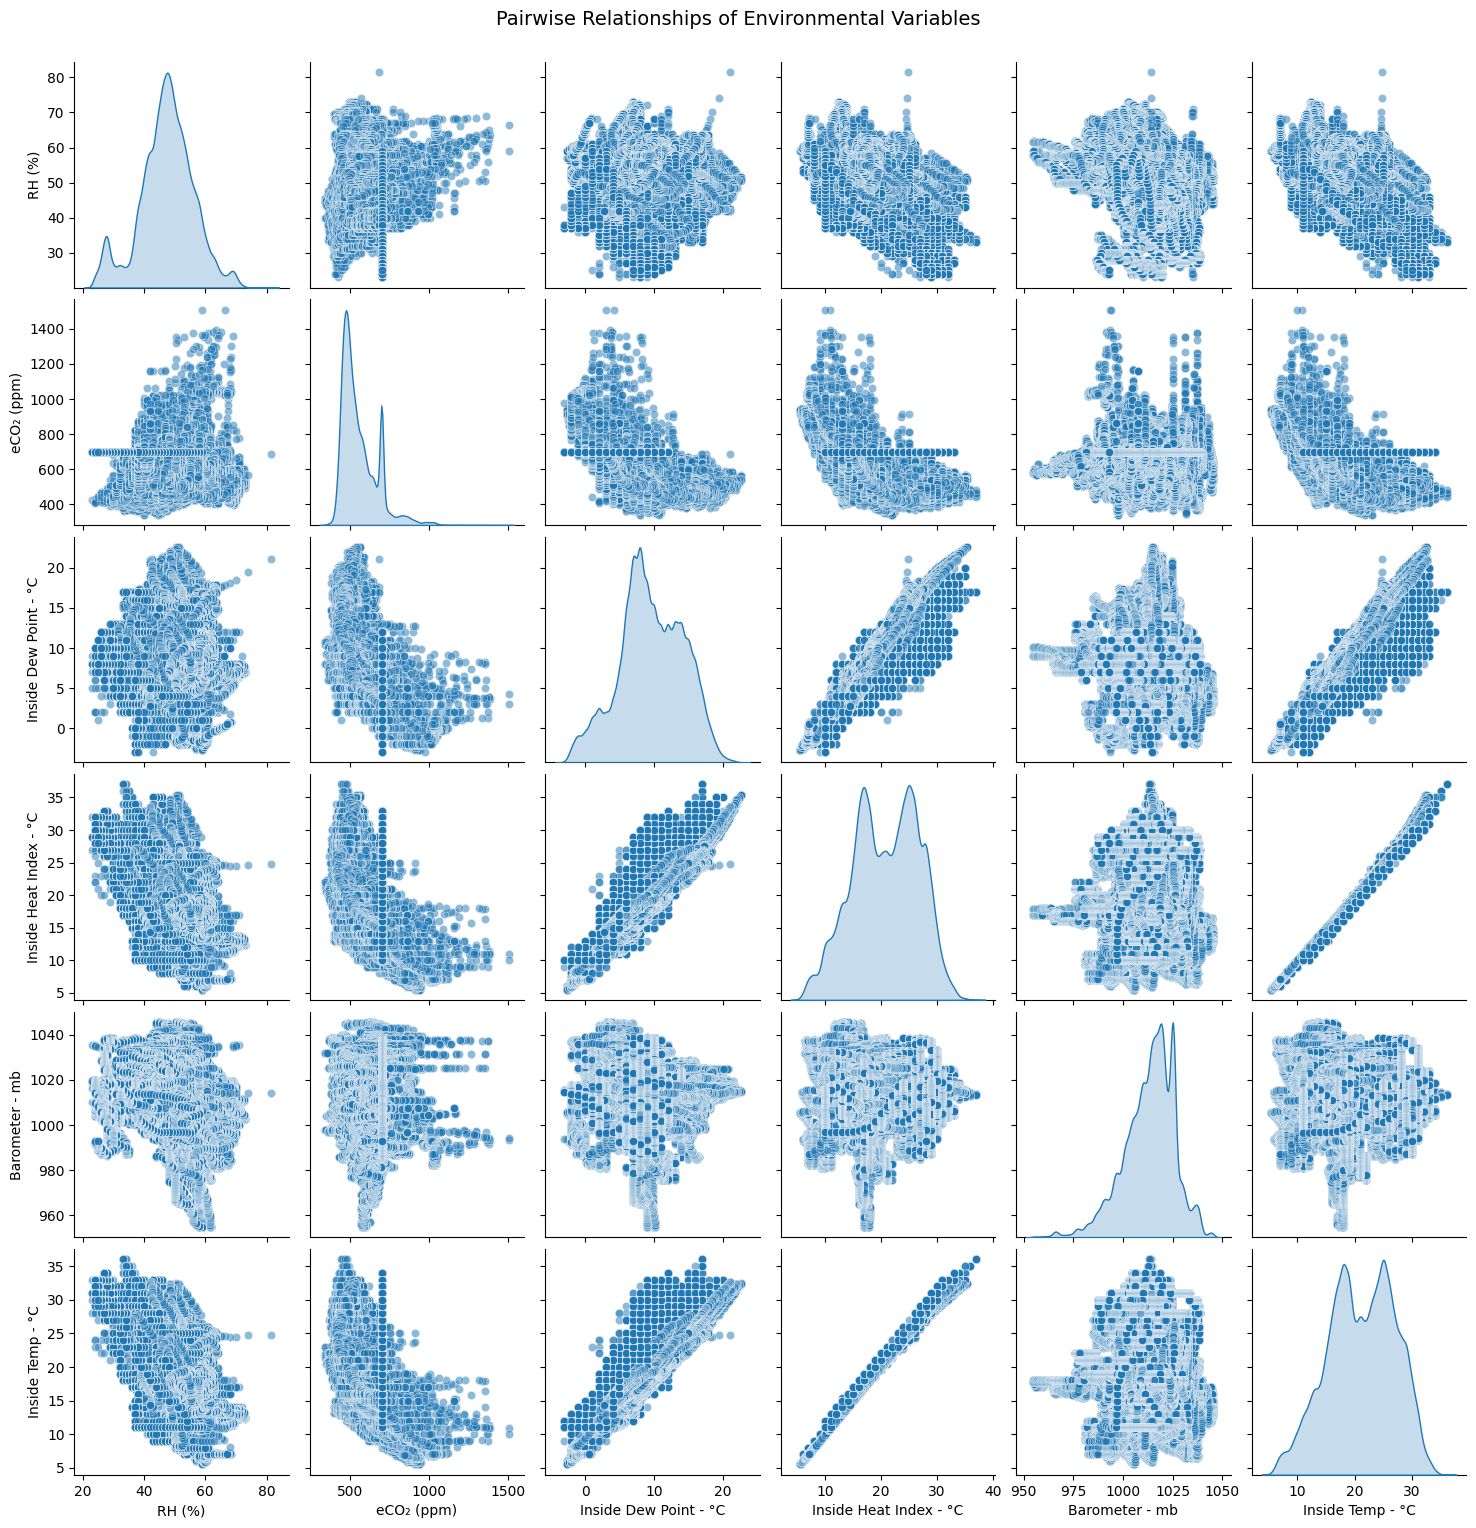

In [66]:
sns.pairplot(df_combined[variables], diag_kind="kde", plot_kws={"alpha": 0.5})
plt.suptitle("Pairwise Relationships of Environmental Variables", fontsize=14, y=1.02)
plt.show()

*The pairwise relationships reveal several key insights. Inside Temperature and Inside Heat Index show a nearly perfect linear relationship, reinforcing their strong correlation. Similarly, Dew Point has a strong positive relationship with Temperature and Heat Index, which aligns with expectations. eCO₂ exhibits a scattered pattern with other variables, suggesting a weaker and more complex relationship. However, it appears to have a somewhat inverse relationship with Dew Point and Temperature. Relative Humidity is broadly distributed and shows an inverse relationship with both Temperature and Heat Index. Barometric pressure does not display a clear relationship with most variables, reaffirming its weak correlation as seen earlier. Overall, the scatterplots support previous observations, with strong dependencies among temperature-related features and a more complex interaction with air quality indicators like eCO₂ and RH.*

In [67]:
# Define the output directory and file path
output_dir = "./data"
os.makedirs(output_dir, exist_ok=True)

# Define the file path for the cleaned dataset
cleaned_df_combined = os.path.join(output_dir, "Final_Combined_Data.csv")

# Save the cleaned dataframe to a CSV file
df_combined.to_csv(cleaned_df_combined, index=False)

# Confirm the saved file
print(f"Data saved successfully as '{cleaned_df_combined}'")

Data saved successfully as './data/Final_Combined_Data.csv'


## **AI Models for Prediction**

### **1. Indoor Temperature Prediction Model**
#### **Target Variable:**
- **Inside Temp (°C)** → Predicting indoor temperature based on environmental factors.

#### **Features:**
- **RH (%)** → Relative humidity, which affects temperature perception.
- **eCO₂ (ppm)** → Higher CO₂ levels can impact air circulation and temperature.
- **Inside Dew Point (°C)** → Indicates moisture content in the air, influencing temperature regulation.
- **Inside Heat Index (°C)** → Represents how hot it feels based on humidity and temperature.
- **Barometer (mb)** → Air pressure can influence temperature variations.

---

### **2. Indoor Air Quality Prediction Model**
#### **Target Variable:**
- **eCO₂ (ppm)** → Predicting equivalent CO₂ levels to assess indoor air quality.

#### **Features:**
- **RH (%)** → Humidity can impact air quality and ventilation efficiency.
- **Inside Temp (°C)** → Temperature changes can influence CO₂ levels and ventilation needs.
- **Inside Dew Point (°C)** → Higher dew points may correlate with increased CO₂ retention.
- **Inside Heat Index (°C)** → Heat index fluctuations can indicate ventilation and air circulation.
- **Barometer (mb)** → Air pressure shifts can impact indoor CO₂ concentration levels.

---

Each model will use **historical time-series data** with appropriate preprocessing, feature scaling, and model validation techniques. The models may be optimized using **time-series forecasting techniques (e.g., ARIMA, LSTMs, or regression-based approaches).**


In [68]:
# Ensure TensorFlow uses GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
        print(e)

### Models
*LSTM*

In [69]:
# Load Data
df = pd.read_csv("./data/Final_Combined_Data.csv", parse_dates=["DateTime"])
df = df.sort_values("DateTime").reset_index(drop=True)
df.dropna(inplace=True)

print("Loaded data shape:", df.shape)
df.head(3)

Loaded data shape: (112622, 8)


DateTime  RH (%)  eCO₂ (ppm)  Inside Dew Point - °C  \
0 2022-12-31 23:53:24    73.0       518.0                    6.9   
1 2023-01-01 00:00:00    68.0       518.0                    8.0   
2 2023-01-01 00:00:55    73.0       520.0                    7.0   

   Inside Heat Index - °C  Barometer - mb  Inside Temp - °C         Sensor  
0                    12.3          1002.6              12.3  EcoLab Ground  
1                    13.0          1002.6              13.0    WeatherLink  
2                    12.4          1002.6              12.4  EcoLab Ground

In [70]:
df.columns

Index(['DateTime', 'RH (%)', 'eCO₂ (ppm)', 'Inside Dew Point - °C',
       'Inside Heat Index - °C', 'Barometer - mb', 'Inside Temp - °C',
       'Sensor'],
      dtype='object')

In [71]:
# Define features for LSTM (last column is the target: Inside Temp)
lstm_features = ["RH (%)", "eCO₂ (ppm)", "Inside Dew Point - °C",
                 "Inside Heat Index - °C", "Barometer - mb", "Inside Temp - °C"]

df_lstm = df[lstm_features].copy()
df_lstm.dropna(inplace=True)

# 80% train, 20% test
train_size = int(len(df_lstm) * 0.8)
train_data, test_data = df_lstm.iloc[:train_size], df_lstm.iloc[train_size:]

# Scale all features to [0,1]
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data.values)
test_scaled = scaler.transform(test_data.values)

# Define sequence length
SEQ_LEN = 24

def create_sequences(data_array, seq_len=SEQ_LEN):
    X, y = [], []
    for i in range(len(data_array) - seq_len):
        X.append(data_array[i: i + seq_len, :])
        y.append(data_array[i + seq_len, -1])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled, SEQ_LEN)
X_test, y_test = create_sequences(test_scaled, SEQ_LEN)

print("LSTM -> X_train:", X_train.shape, "y_train:", y_train.shape)
print("LSTM -> X_test :", X_test.shape,  "y_test :", y_test.shape)

LSTM -> X_train: (90073, 24, 6) y_train: (90073,)
LSTM -> X_test : (22501, 24, 6) y_test : (22501,)


In [75]:
# Train LSTM Model
def train_lstm(X_train_seq, y_train_seq, X_val_seq, y_val_seq):
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
        Dropout(0.4),
        LSTM(64, return_sequences=False),
        Dropout(0.4),
        Dense(32, activation="relu"),
        Dense(1)
    ])

    model.compile(optimizer=AdamW(1e-4), loss="mse", metrics=["mae"])

    # TensorFlow's EarlyStopping
    early_stopping = EarlyStopping(monitor="val_loss", patience=5, mode="min", restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=3, min_lr=1e-6)

    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=25, batch_size=32,
        callbacks=[early_stopping, reduce_lr], verbose=1
    )

    return model, history

# Train the model
model_lstm, history_lstm = train_lstm(X_train, y_train, X_test, y_test)
model_lstm.save("lstm_model.keras")

Epoch 1/25
2815/2815 [==============================] - 87s 29ms/step - loss: 0.0065 - mae: 0.0549 - val_loss: 0.0087 - val_mae: 0.0763 - lr: 1.0000e-04
Epoch 2/25
2815/2815 [==============================] - 81s 29ms/step - loss: 0.0023 - mae: 0.0373 - val_loss: 0.0059 - val_mae: 0.0551 - lr: 1.0000e-04
Epoch 3/25
2815/2815 [==============================] - 82s 29ms/step - loss: 0.0017 - mae: 0.0330 - val_loss: 0.0030 - val_mae: 0.0419 - lr: 1.0000e-04
Epoch 4/25
2815/2815 [==============================] - 82s 29ms/step - loss: 0.0015 - mae: 0.0310 - val_loss: 0.0019 - val_mae: 0.0342 - lr: 1.0000e-04
Epoch 5/25
2815/2815 [==============================] - 81s 29ms/step - loss: 0.0014 - mae: 0.0297 - val_loss: 0.0018 - val_mae: 0.0336 - lr: 1.0000e-04
Epoch 6/25
2815/2815 [==============================] - 81s 29ms/step - loss: 0.0013 - mae: 0.0286 - val_loss: 0.0016 - val_mae: 0.0330 - lr: 1.0000e-04
Epoch 7/25
2815/2815 [==============================] - 81s 29ms/step - loss: 0.00

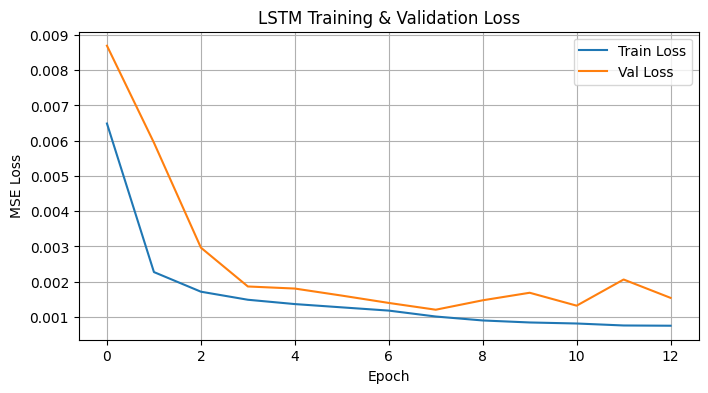

In [76]:
# Plot training curves
plt.figure(figsize=(8, 4))
plt.plot(history_lstm.history["loss"], label="Train Loss")
plt.plot(history_lstm.history["val_loss"], label="Val Loss")
plt.title("LSTM Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid()
plt.show()

In [77]:
# Generate Predictions
y_pred = model_lstm.predict(X_test)

# Rebuild for inverse transform
num_samples = len(y_pred)
num_features = len(lstm_features)

temp_scaled_pred = np.zeros((num_samples, num_features))
temp_scaled_pred[:, :-1] = X_test[:, -1, :-1]  # Last step's feature context
temp_scaled_pred[:, -1] = y_pred.ravel()

inv_pred = scaler.inverse_transform(temp_scaled_pred)[:, -1]

# Actual Values
temp_scaled_actual = np.zeros((num_samples, num_features))
temp_scaled_actual[:, :-1] = X_test[:, -1, :-1]
temp_scaled_actual[:, -1] = y_test
inv_actual = scaler.inverse_transform(temp_scaled_actual)[:, -1]

# Compute RMSE
lstm_rmse = np.sqrt(mean_squared_error(inv_actual, inv_pred))
print(f"LSTM Test RMSE: {lstm_rmse:.3f}")

704/704 [==============================] - 8s 10ms/step
LSTM Test RMSE: 1.060


704/704 [==============================] - 7s 10ms/step


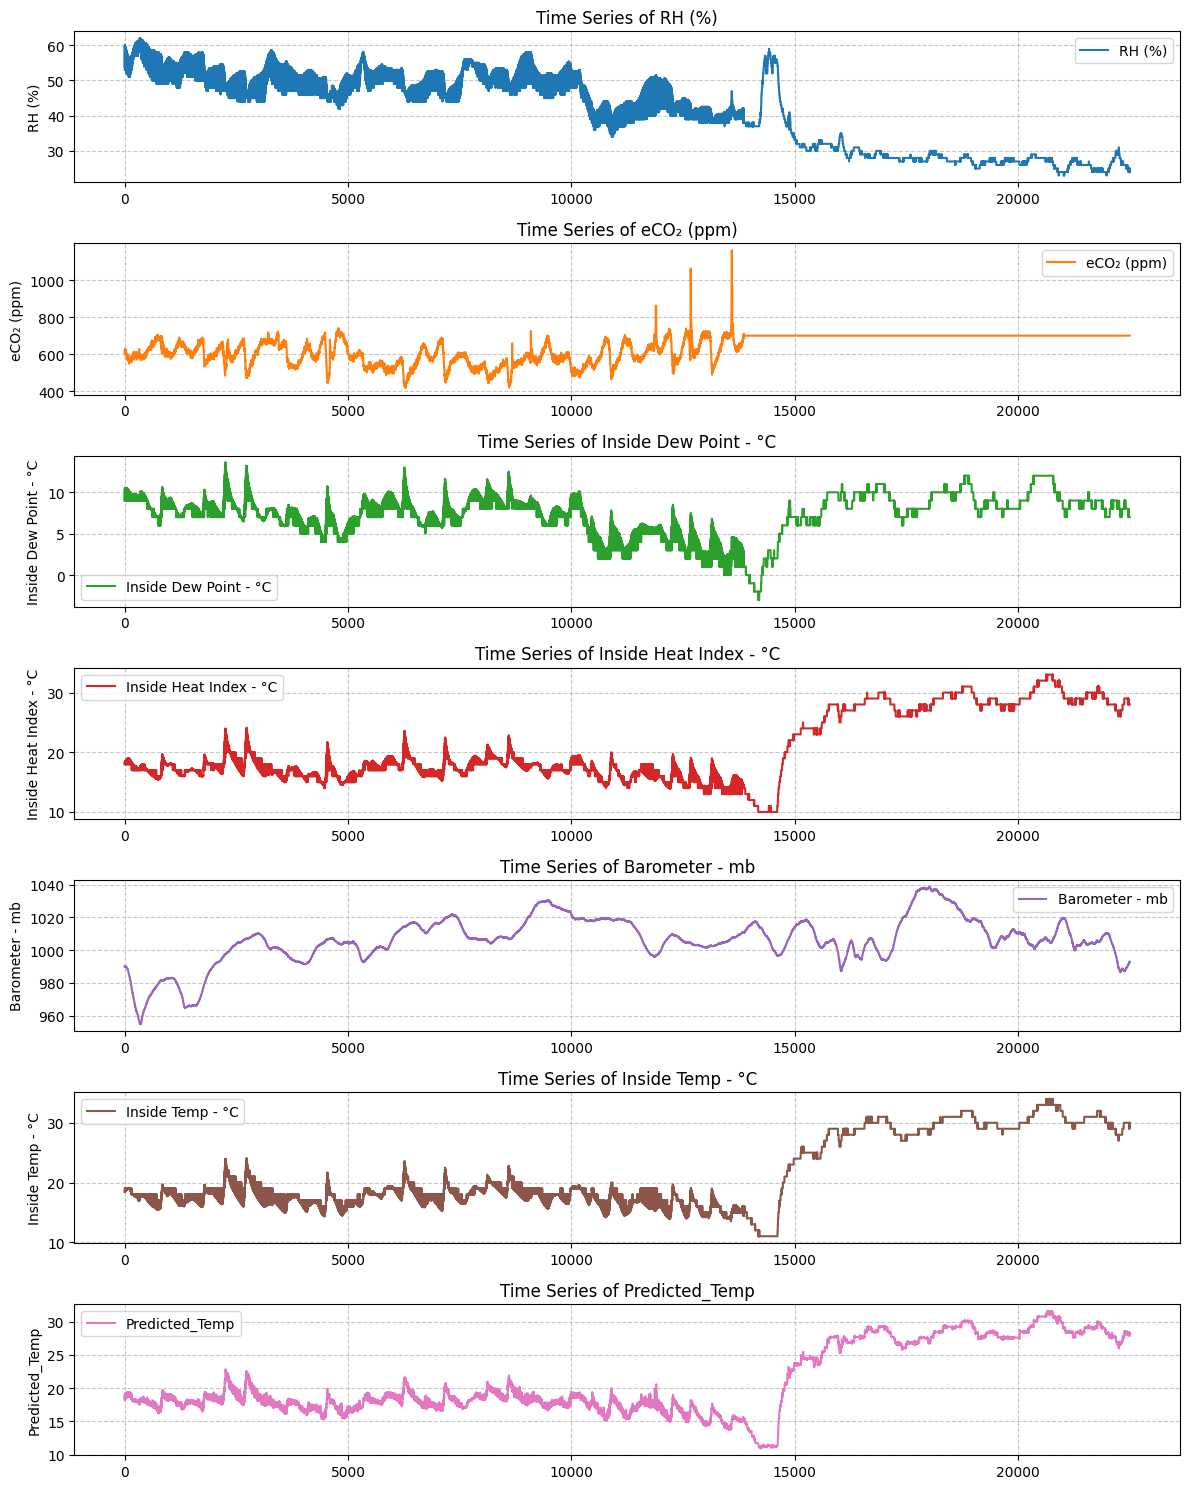

In [81]:
# Ensure y_test, X_test, scaler, and lstm_features are available
if 'y_test' not in locals() or 'X_test' not in locals() or 'scaler' not in locals() or 'lstm_features' not in locals():
    raise ValueError("Ensure y_test, X_test, scaler, and lstm_features are correctly defined in the environment.")

# compute inverse transformed actual and predicted values
num_samples = len(y_test)
num_features = len(lstm_features)

# Actual Values
temp_scaled_actual = np.zeros((num_samples, num_features))
temp_scaled_actual[:, :-1] = X_test[:, -1, :-1]
temp_scaled_actual[:, -1] = y_test
inv_actual = scaler.inverse_transform(temp_scaled_actual)

# Predicted Values
y_pred = model_lstm.predict(X_test)
temp_scaled_pred = np.zeros((num_samples, num_features))
temp_scaled_pred[:, :-1] = X_test[:, -1, :-1]
temp_scaled_pred[:, -1] = y_pred.ravel()
inv_pred = scaler.inverse_transform(temp_scaled_pred)

# Ensure proper alignment with numerical indices
test_index_lstm = range(len(inv_actual))

# Create DataFrame for visualization with all variables
df_test_lstm = pd.DataFrame(inv_actual, columns=lstm_features)
df_test_lstm["Predicted_Temp"] = inv_pred[:, -1]
df_test_lstm["Index"] = test_index_lstm
df_test_lstm.set_index("Index", inplace=True)

# Generate unique colors for each variable
colors = sns.color_palette("tab10", len(df_test_lstm.columns))

# Create subplots for all variables with different colors
fig, axes = plt.subplots(len(df_test_lstm.columns), 1, figsize=(12, 15))

for i, (col, color) in enumerate(zip(df_test_lstm.columns, colors)):
    axes[i].plot(df_test_lstm.index, df_test_lstm[col], label=col, linewidth=1.5, color=color)
    axes[i].set_title(f"Time Series of {col}")
    axes[i].set_ylabel(col)
    axes[i].grid(True, linestyle="--", alpha=0.7)
    axes[i].legend()

# Adjust layout
plt.tight_layout()
plt.show()

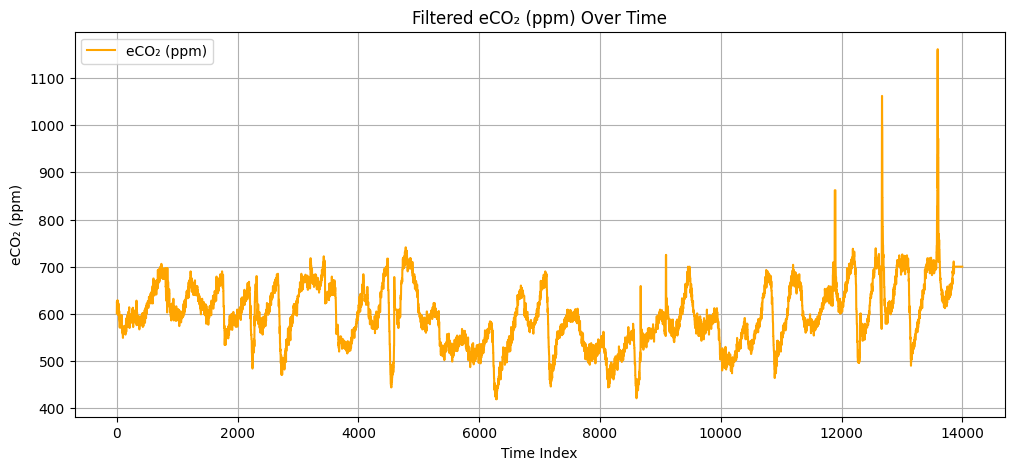

In [82]:
# Remove Affected Period
df_test_lstm = df_test_lstm[df_test_lstm.index < 14000]

# Re-Plot after
plt.figure(figsize=(12, 5))
plt.plot(df_test_lstm.index, df_test_lstm["eCO₂ (ppm)"], label="eCO₂ (ppm)", color="orange")
plt.title("Filtered eCO₂ (ppm) Over Time")
plt.xlabel("Time Index")
plt.ylabel("eCO₂ (ppm)")
plt.legend()
plt.grid()
plt.show()

704/704 [==============================] - 7s 10ms/step


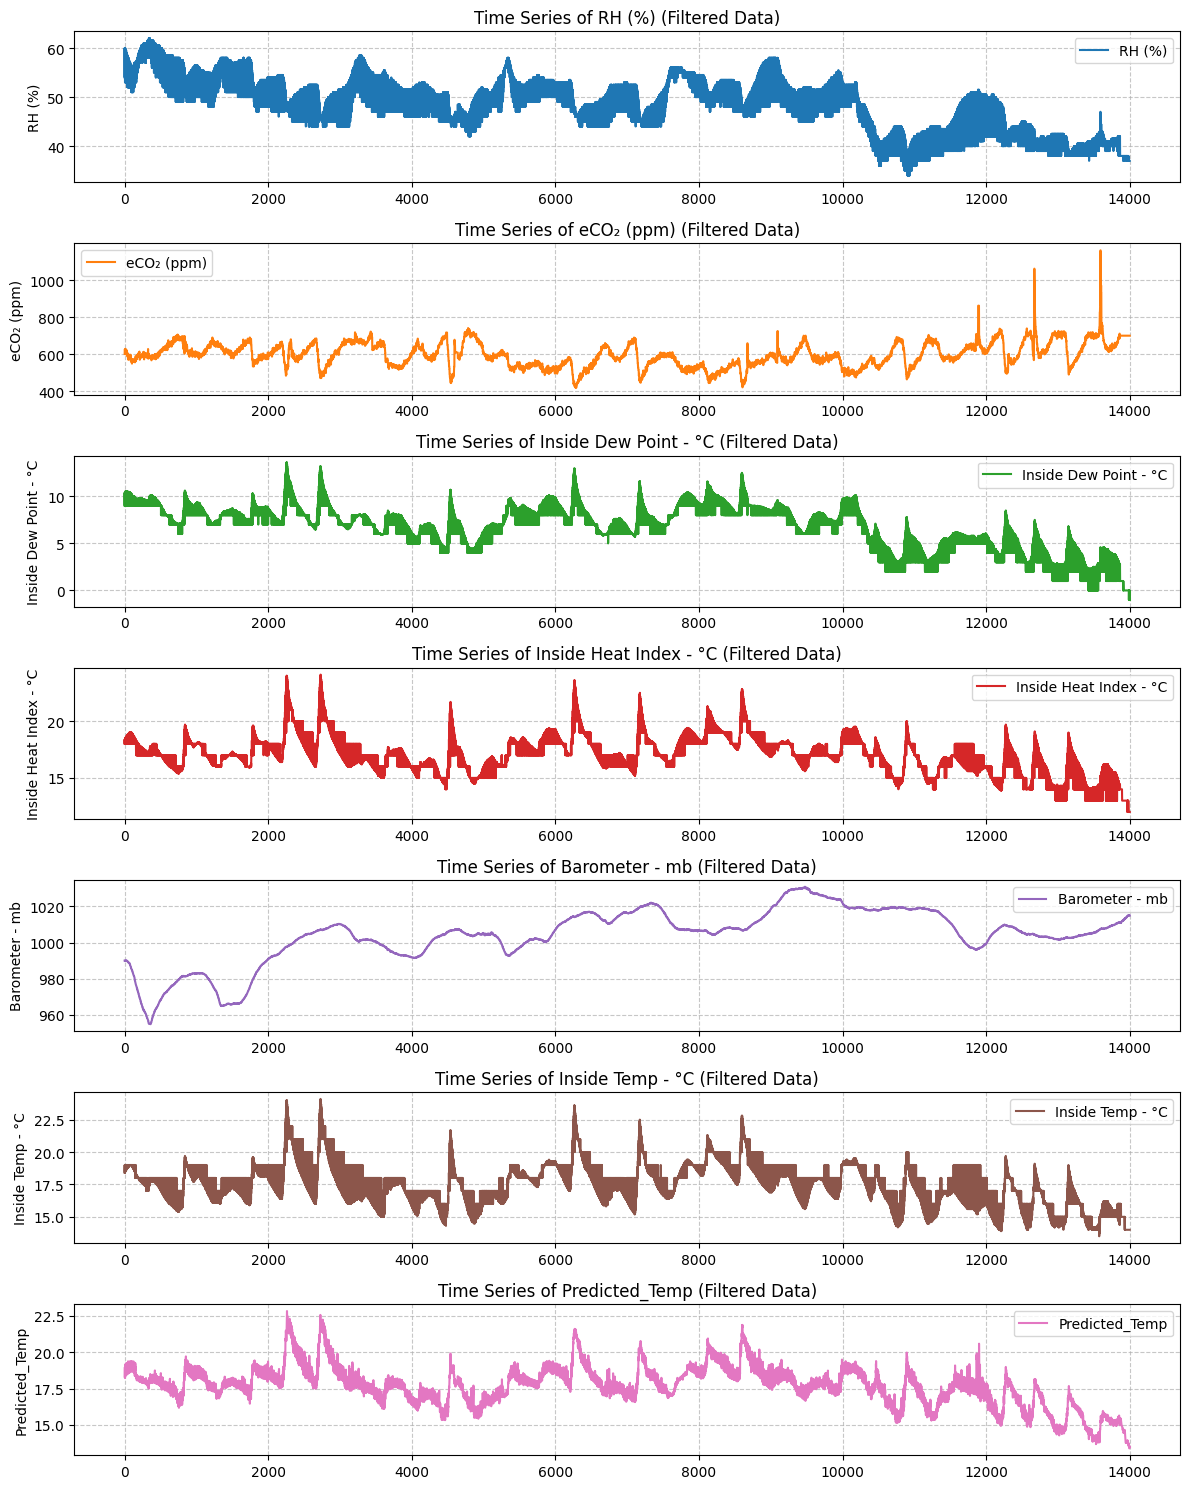

In [84]:
# Recompute inverse transformed actual and predicted values
num_samples = len(y_test)
num_features = len(lstm_features)

# Actual Values
temp_scaled_actual = np.zeros((num_samples, num_features))
temp_scaled_actual[:, :-1] = X_test[:, -1, :-1]
temp_scaled_actual[:, -1] = y_test
inv_actual = scaler.inverse_transform(temp_scaled_actual)

# Predicted Values
y_pred = model_lstm.predict(X_test)
temp_scaled_pred = np.zeros((num_samples, num_features))
temp_scaled_pred[:, :-1] = X_test[:, -1, :-1]
temp_scaled_pred[:, -1] = y_pred.ravel()
inv_pred = scaler.inverse_transform(temp_scaled_pred)

# Ensure proper alignment with numerical indices
test_index_lstm = range(len(inv_actual))

# Create DataFrame for visualization with all variables
df_test_lstm = pd.DataFrame(inv_actual, columns=lstm_features)
df_test_lstm["Predicted_Temp"] = inv_pred[:, -1]
df_test_lstm["Index"] = test_index_lstm
df_test_lstm.set_index("Index", inplace=True)

# Remove affected period (after index 14000)
df_test_lstm_cleaned = df_test_lstm[df_test_lstm.index < 14000]

# Generate unique colors for each variable
colors = sns.color_palette("tab10", len(df_test_lstm_cleaned.columns))

# Create subplots for all variables with different colors
fig, axes = plt.subplots(len(df_test_lstm_cleaned.columns), 1, figsize=(12, 15))

for i, (col, color) in enumerate(zip(df_test_lstm_cleaned.columns, colors)):
    axes[i].plot(df_test_lstm_cleaned.index, df_test_lstm_cleaned[col], label=col, linewidth=1.5, color=color)
    axes[i].set_title(f"Time Series of {col} (Filtered Data)")
    axes[i].set_ylabel(col)
    axes[i].grid(True, linestyle="--", alpha=0.7)
    axes[i].legend()

# Adjust layout
plt.tight_layout()
plt.show()

## Re-Train after Hyperameter Tuning

In [85]:
# Adjust train-test split to 70% training and 30% testing
train_size = int(len(df_lstm) * 0.7)
train_data, test_data = df_lstm.iloc[:train_size], df_lstm.iloc[train_size:]

# Scale features
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data.values)
test_scaled = scaler.transform(test_data.values)

# Define sequence length
SEQ_LEN = 24

# Create sequences
X_train, y_train = create_sequences(train_scaled, SEQ_LEN)
X_test, y_test = create_sequences(test_scaled, SEQ_LEN)

print(f"New Train Shape: X={X_train.shape}, y={y_train.shape}")
print(f"New Test Shape: X={X_test.shape}, y={y_test.shape}")

New Train Shape: X=(78811, 24, 6), y=(78811,)
New Test Shape: X=(33763, 24, 6), y=(33763,)


In [86]:
# Define Learning Rate Schedule (Exponential Decay)
def lr_schedule(epoch, lr):
    return lr * 0.95  # Decays by 5% per epoch

lr_scheduler = LearningRateScheduler(lr_schedule)

# Define and train the optimized model
def train_lstm_optimized(X_train_seq, y_train_seq, X_val_seq, y_val_seq):
    model = Sequential([
        LSTM(256, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), kernel_regularizer=l2(1e-4)),
        Dropout(0.6),
        LSTM(128, return_sequences=False, kernel_regularizer=l2(1e-4)),
        Dropout(0.5),
        Dense(64, activation="relu"),
        Dense(1)
    ])

    model.compile(optimizer=Adam(3e-4), loss="mse", metrics=["mae"])  # Slightly higher learning rate

    early_stopping = EarlyStopping(monitor="val_loss", patience=4, mode="min", restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, min_lr=1e-6)

    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=25, batch_size=64,
        callbacks=[early_stopping, reduce_lr, lr_scheduler], verbose=1
    )

    return model, history

# Retrain the optimized model
model_lstm_optimized, history_lstm_optimized = train_lstm_optimized(X_train, y_train, X_test, y_test)

# Save the trained model
model_lstm_optimized.save("lstm_model_optimized.keras")

Epoch 1/25
1232/1232 [==============================] - 87s 67ms/step - loss: 0.0155 - mae: 0.0471 - val_loss: 0.0077 - val_mae: 0.0436 - lr: 2.8500e-04
Epoch 2/25
1232/1232 [==============================] - 82s 66ms/step - loss: 0.0047 - mae: 0.0336 - val_loss: 0.0041 - val_mae: 0.0395 - lr: 2.7075e-04
Epoch 3/25
1232/1232 [==============================] - 82s 66ms/step - loss: 0.0025 - mae: 0.0303 - val_loss: 0.0028 - val_mae: 0.0380 - lr: 2.5721e-04
Epoch 4/25
1232/1232 [==============================] - 81s 66ms/step - loss: 0.0018 - mae: 0.0294 - val_loss: 0.0027 - val_mae: 0.0396 - lr: 2.4435e-04
Epoch 5/25
1232/1232 [==============================] - 82s 66ms/step - loss: 0.0015 - mae: 0.0288 - val_loss: 0.0014 - val_mae: 0.0298 - lr: 2.3213e-04
Epoch 6/25
1232/1232 [==============================] - 81s 66ms/step - loss: 0.0014 - mae: 0.0285 - val_loss: 0.0017 - val_mae: 0.0339 - lr: 2.2053e-04
Epoch 7/25
1232/1232 [==============================] - 82s 66ms/step - loss: 0.00

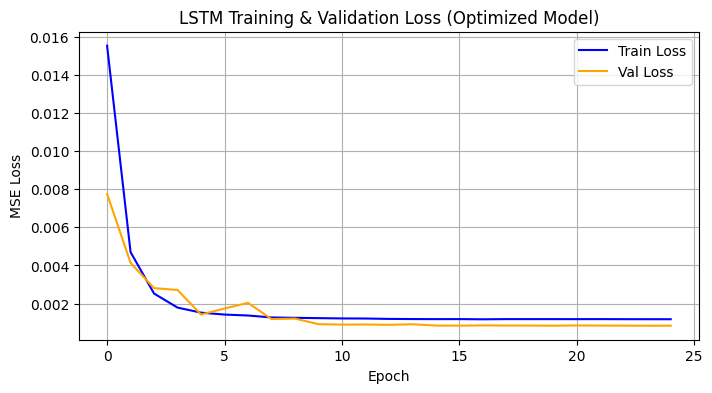

In [87]:
# Plot Training and Validation Loss for the Optimized Model
plt.figure(figsize=(8, 4))
plt.plot(history_lstm_optimized.history["loss"], label="Train Loss", color="blue")
plt.plot(history_lstm_optimized.history["val_loss"], label="Val Loss", color="orange")
plt.title("LSTM Training & Validation Loss (Optimized Model)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid()
plt.show()